In [58]:
#################################################################### Loading packages ####################################################################
import sys as sys
import os
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import *
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import euclidean_distances 
import pandas as pd
from scipy.optimize import dual_annealing
from joblib import Parallel, delayed
import psutil
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process.kernels import Matern

#################################################################### Loading GNM ####################################################################
model_version = 0 
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')

import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))

GNM_output = pickle.load( open(os.path.join(path_,"test_output_1979_1993-03_train20y.pkl"),"rb") )

#################################################################### Problematic locations? ###############################################################

location_keys = list(GNM_output.keys())                 # '([0, 16], [44, 60])', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'


# May have to remove a location that doesn't have the correct number of days:
#location_keys.remove(location_keys[344]) #to remove for gamma_20_20
#location_keys.remove(location_keys[171]) # to remove for gamma_20_20_unseen
#location_keys.remove(location_keys[344]) # to remove for 10 y train
#location_keys.remove(location_keys[312])  # to remove for 2y_test
location_keys.remove(location_keys[336]) #to remove for gamma_20_20 train  
#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [ int(re.findall(r'\d+',string)[0]) for string in location_key.split(',')]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][row][column]

#location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = [pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date']]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
               continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]]) # parameters except location
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([temp_lat_lon[1]-8+row,(temp_lat_lon[2])+6+col]) #location
            for param_idx,param in enumerate(output_keys[:-1]):
                for day in range(len(GNM_output[location_keys[0]]['pred_mu'])):
                    qqq = [location,param,day,row,col]
                    GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))

#################################################################### Elevation data ####################################################################
import netCDF4 as nc
fn = 'topo_0.1_degree.nc'
ds = nc.Dataset(fn)
h = ds['Band1'][:]
h = np.flip(np.matrix(h),axis=0)
topo_dist = euclidean_distances(np.array([h[loc[5][0],loc[5][1]+2] for loc in GNM_landonly]).reshape(-1,1))

100%|██████████| 344/344 [01:05<00:00,  5.26it/s]


In [2]:
qqq

['([80, 96], [64, 80])', 'pred_mu', 5068, 0, 0]

In [3]:
for i,loc in enumerate(location_keys):
    if loc=='([80, 96], [64, 80])':
        print(i,loc)

336 ([80, 96], [64, 80])


### Plotting to make sure everything is in order

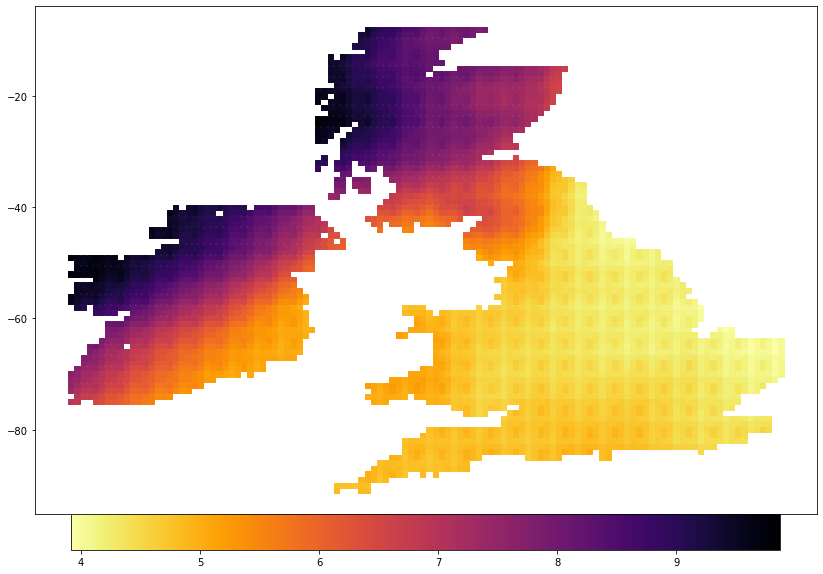

In [53]:
#check rain is correct
for day in range(10,11):
    fig = plt.gcf() 
    fig.set_size_inches(14,10)

    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(GNM_landonly))],[-GNM_landonly[loc][5][0] for loc in range(len(GNM_landonly))],c=[GNM_landonly[loc][0][day] for loc in range(len(GNM_landonly))],cmap='inferno_r',s=27,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.show()

## Forecasts

Has to be done with the train set, so remember to change the JGNM experiment.

### Converting observations to us + Sample covariance matrix?

In [14]:
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'
def get_cdf_gnm(places):
    out=[]
    for idx,place in enumerate(places):
        out.append([])    
        for day in range(len(place[3])):
            scaling = np.random.uniform(size=1)
            obs = place[3][day]
            p = place[4][day]

            if obs==0: # dry day -> 1-p
                out[idx].append(scaling*(1-p))
            else: # rainy day -> (1-p)+p.cdf_x
                mu,disp = place[0][day],place[1][day]
                out[idx].append( (1-p)+(p*scs.gamma(scale=disp*mu,a=1/disp).cdf(obs)) )
    return out

obs_u_all_ = []
for locs in tqdm(np.array_split(np.array(range(len(GNM_landonly))),67)):
    
    size = math.ceil(len(locs)/psutil.cpu_count())
    locs_chuncks = [[GNM_landonly[i] for i in locs][x:x+size] for x in range(0,len(locs), size)]
    
    obs_u_all_.append( Parallel(n_jobs=psutil.cpu_count())(delayed(get_cdf_gnm)(chunck) for chunck in locs_chuncks) )



  1%|▏         | 1/67 [00:13<14:41, 13.36s/it]


KeyboardInterrupt: 

In [106]:
# Save
with open('obs_u_all_.txt','wb') as f:
    pickle.dump(obs_u_all_,f)
'''
#Load 
with open('obs_u_all_.txt','rb') as f:
    obs_u_all_ = pickle.load(f)'''

"\n#Load \nwith open('obs_u_all_.txt','rb') as f:\n    obs_u_all_ = pickle.load(f)"

C:\Users\u1819911\AppData\Local\Temp\ipykernel_16044\2457680219.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  obs_u_all = np.concatenate(np.array(obs_u_all_).flatten()).flatten()
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


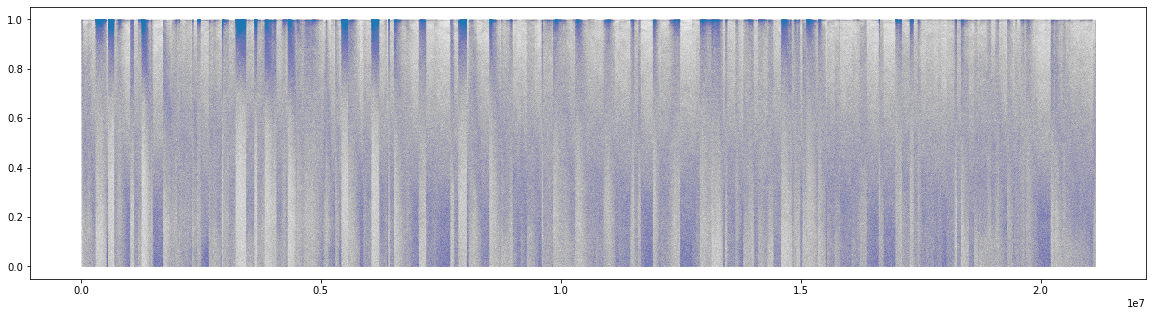

In [134]:
plt.figure(figsize=(20,5))
obs_u_all = np.concatenate(np.array(obs_u_all_).flatten()).flatten()
obs_u_all = np.array(obs_u_all).astype(float)
plt.scatter( range(len(obs_u_all)),obs_u_all,s=0.000005)
plt.show()

### Difference between adding and multiplying kernels

In [104]:
from sklearn.gaussian_process.kernels import Matern
M_topo,M_dist = Matern(length_scale=9000,nu=6.5).__call__(topo_dist[:2000,:2000]) , Matern(length_scale=9000,nu=6.5).__call__(dist_mat[:2000,:2000]) 
test_multiply =np.multiply( M_topo,M_dist)
test_add =np.add( M_topo,M_dist )/2

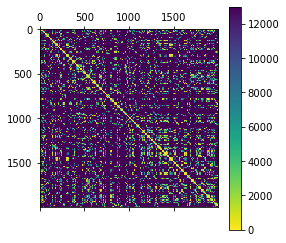

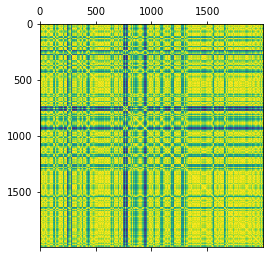

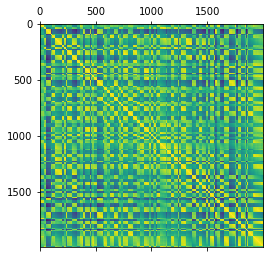

In [107]:
plt.matshow(np.multiply(topo_dist[:2000,:2000],dist_mat[:2000,:2000]),cmap='viridis_r',vmax=13000)
plt.colorbar()
plt.matshow(topo_dist[:2000,:2000],cmap='viridis_r')
plt.matshow(dist_mat[:2000,:2000],cmap='viridis_r')

### Finding a local set of points

In [99]:
# finds the indexes (gives a nested array).Add [0] to get it as an array.
np.where([math.dist(GNM_landonly[k][5],GNM_landonly[10][5])<2 for k in range(len(GNM_landonly))])[0]
# gives the loctions themselves
[GNM_landonly[i][5] for i in np.where([math.dist(GNM_landonly[k][5],GNM_landonly[10][5])<2 for k in range(len(GNM_landonly))])[0]]

[[41, 42],
 [42, 42],
 [43, 42],
 [41, 43],
 [42, 43],
 [43, 43],
 [41, 44],
 [42, 44],
 [43, 44]]

990


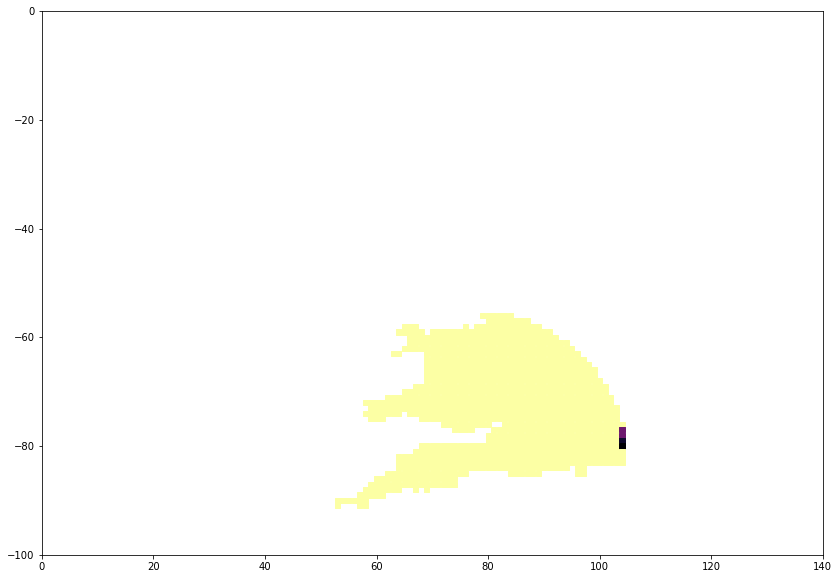

In [724]:
# spacially subsampling
fig = plt.gcf() 
fig.set_size_inches(14,10)
random_center = np.random.choice(range(len(GNM_landonly))) 
locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<28 for k in range(len(GNM_landonly))])[0]
print(len(locs))

plt.scatter([GNM_landonly[loc][5][1] for loc in locs],
[-GNM_landonly[loc][5][0] for loc in locs],
c=[GNM_landonly[loc][3][day] for loc in locs],
cmap='inferno_r',s=27,marker='s')

plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

In [725]:
def generate_subsample_locs(locs_nb):
    locs=[]
    while len(locs)<locs_nb:
        random_center = np.random.choice(range(len(GNM_landonly))) 
        locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<(np.sqrt(locs_nb/np.pi)+3) for k in range(len(GNM_landonly))])[0]
    return np.random.choice(locs,size=locs_nb,replace=False)    

200


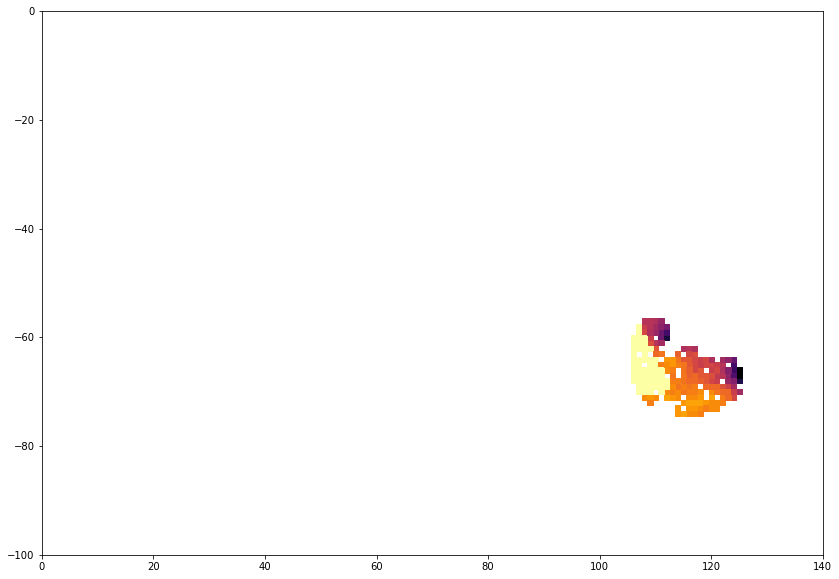

In [759]:
# Alternative: make sure to get the same number of locs.

# spacially subsampling
fig = plt.gcf() 
fig.set_size_inches(14,10)
locs = generate_subsample_locs(locs_nb=200)
print(len(locs))

plt.scatter([GNM_landonly[loc][5][1] for loc in locs],
[-GNM_landonly[loc][5][0] for loc in locs],
c=[GNM_landonly[loc][3][423] for loc in locs],
cmap='inferno_r',s=27,marker='s')

plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

### Estimation with Scoring Rules

In [5]:
# Transform observations into x with respect to their marginals and then to a normal scale. (1-p) + p*CDF(x), 1m30

obs_norm_all = []
for day in tqdm(range(len(GNM_landonly[0][1]))):
    
    # Transform observations into Us with respect to their marginals. (1-p) + p*CDF(x)
    us = np.array(1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))]) + np.multiply( # 1-p +
                        [GNM_landonly[l][4][day] for l in range(len(GNM_landonly))],                     # p *
                        scs.gamma(                                                          # CDF(x)
                            scale=np.multiply([GNM_landonly[l][0][day] for l in range(len(GNM_landonly))],[GNM_landonly[l][1][day] for l in range(len(GNM_landonly))]), # scale = mu * disp
                            a=np.reciprocal([GNM_landonly[l][1][day] for l in range(len(GNM_landonly))])                                                   # a = shape = 1/disp 
                        ).cdf([GNM_landonly[l][3][day] for l in range(len(GNM_landonly))])               # x : observed rain
                    ))

    # Make sure no Us are above the precision of norm.ppf. Fix them to the next highest value of that day.
    if np.sum([us>=1-(1e-15)])>0:
        us[us>1]=np.max(us[us<1-(1e-15)])

    # Transform Us into normal variables.
    obs_norm_all.append(
        scs.norm.ppf(us)
    )
obs_norm_all = np.nan_to_num(obs_norm_all, copy=True, nan=8.5, posinf=8.5, neginf=-8.5)

censor_levels_di = []

for day in tqdm(range(len(GNM_landonly[0][1]))):
    
    # Transform observations into Us with respect to their marginals. (1-p) + p*CDF(x)
    ui = np.array(1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])) # 1-p

    #print(ui)

    # Transform Us into normal variables.
    censor_levels_di.append(
        scs.norm.ppf(ui)
    )

censor_levels_di = np.array(censor_levels_di)


100%|██████████| 5173/5173 [00:06<00:00, 796.13it/s]


In [6]:
def generate_subsample_locs(location_number):
    l=[]
    while len(l)<location_number:
        random_center = np.random.choice(range(len(GNM_landonly))) 
        l = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<(np.sqrt(location_number/np.pi)+30) for k in range(len(GNM_landonly))])[0]
    return np.random.choice(l,size=location_number,replace=False)    

subset_locations = []
for s in range(250):
    subset_locations.append(generate_subsample_locs(location_number=800))

In [7]:
def Spatial_Score_add_first(theta,locs_nb,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix=None):
    '''
    theta: vector of 3 [Matern_param, coef_distmat, coef_topomat]. The coefs are applied to the matricies to form the ditance matrix used as input in the Matern kernel to form the covariance.
    locs_subsets: subsets of locations with the same number of locs in each.
    days_nb: how many days to include on the subsample.
    sim_nb: number of simulation draws to compare with original data in the score.
    observations_x: x, observed rainfall transformed to a Gaussian normal scale. This is the data that we try to emulate.
    censor_levels_di: d, probability of no rain (1-p) transformed to a normal scale. These are used to censor simulations (x') when comparingt to x.
    '''
    # Subsample locations. Choose a random snippet from the subsets in locs_subsets.
        # OLD: Subsample locations. Choose a random center and take all locations within fixed radius.
    '''random_center = np.random.choice(range(len(GNM_landonly))) 
    locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center][5])<radius for k in range(len(GNM_landonly))])[0]
    locs_nb = len(locs)'''
        # New: pick one of the lists of location indexes from the locs_subsets provided.
    locs = generate_subsample_locs(locs_nb)

    # Subsample days.
    days = np.random.choice(range(len(GNM_landonly[0][0])),size=days_nb,replace=False)

    # Select relevant subsamples of data.
    x = observations_x[days,:][:,locs]
    d = censor_levels_di[days,:][:,locs]
    
    # Create covariance matrix.
    if np.sum(topo_matrix==None):
        cov_mat = theta[1]*np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(dist_matrix[locs,:][:,locs]))+ (1-theta[1])*np.eye(len(locs))
    else:
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(theta[1]*dist_matrix[locs,:][:,locs]+topo_matrix[locs,:][:,locs]))
    
    # Draw samples from the multivariate nromal with appropriate covariance.
    simulations = scs.multivariate_normal(mean=np.zeros(locs_nb),cov=cov_mat,allow_singular=True).rvs(size=sim_nb)
    
    # Censor simulated values and format them into [[sim0-day0,sim0-day1,...,sim0-dayn] ,..., [sim_m-day0,sim_m-day1,...,sim_m-dayn]]. Gives sim_nb*days_nb=m*n vectors of len=locs_nb. 
    censored_sims = np.maximum(np.repeat(simulations,days_nb,axis=0),np.tile(d,(sim_nb,1)))

    # ||x' - x' ||_2 component of energy score
    sims_by_day = [censored_sims[0+k::days_nb] for k in range(days_nb)] # regroup to get [[sim(1,day1), sim(2,day1),...,sim(m,day1)],...,[sim(1,dayn), sim(2,dayn),...,sim(m,dayn)]].
    
    sim_L2_diff = 0
    sims_L1_diff = []
    for sim_day_i in tqdm(sims_by_day): # don't know how to make it more efficient... maybe can parallelize to compute complete score
        
        # ||x' - x' ||_2 component of energy score
            # OLD: einsum from Lorenzos code on each sim_day_i was 9x slower then doing pdist on each sim_day_i. Both give the same answer
        '''
        # matrix of all combinations over i of [vector_i-vector_1, ... , vector_i-vector_n]
        temp_diff_combinations_matrix = sim_day_i.reshape(1,sim_nb,locs_nb)-sim_day_i.reshape(sim_nb,1,locs_nb) 
        # einsum creates a matrix of sum of squares, then take sqrt to get L2.
        sim_L2_diff+=0.5*np.sum(np.sqrt(np.einsum('ijk, ijk -> ij',temp_diff_combinations_matrix,temp_diff_combinations_matrix))) 
        '''
            # New:
        sim_L2_diff+=np.sum(pdist(sim_day_i))

        # |x_k,i - x_k,j| component of Variogram score, averaged over samples k, done for each day, i and j are locations.  
        sims_L1_diff.append( # locs_nb*locs_nb matrix of L1 dists between individual values at different locations, averaged over samples.
            np.mean(np.abs(
                (np.tile(sim_day_i,locs_nb).reshape(locs_nb,sim_nb*locs_nb)-np.repeat(sim_day_i,locs_nb).reshape(locs_nb,sim_nb*locs_nb)).reshape(sim_nb,locs_nb,locs_nb)
                ),axis=0)
            )
    # Add both parts of Energy.
    Energy = np.mean(np.linalg.norm(censored_sims - np.tile(x,(sim_nb,1)),axis=1)) - sim_L2_diff/(days_nb*sim_nb*(sim_nb-1))
    
    # Variogram Score:
        # Inverse distance matrix for the subsample of locations.
    subsampled_inv_dist_mat = np.nan_to_num(np.reciprocal(dist_mat[locs,:][:,locs]),copy=False,nan=0,posinf=0,neginf=0)

    # |x_i-x_j| part of Variogram score. Note this counts each difference twice - that is intended.
        # | [[x_day1] repeated locs_nb times] - [[x_1,1 repeated locs_nb times], ..., [x_1,l repeated locs_nb times]] | which created L1 dist mat for day 1. 
        # These sub-matricies are stacked on top of each other (each sub-matrix for a given day) and the oprations done once.
    x_L1_diff = np.abs(np.tile(x,locs_nb).reshape(days_nb*locs_nb,locs_nb)-np.repeat(x,locs_nb).reshape(days_nb*locs_nb,locs_nb))
    
    Variogram = np.sum(np.multiply(np.tile(subsampled_inv_dist_mat,(days_nb,1)),np.power(np.array(x_L1_diff)-np.array(sims_L1_diff).reshape(days_nb*locs_nb,locs_nb),2)))/days_nb


    out = 60 * Energy + Variogram
    path_.append([theta,out])
    #print(theta,out)
    return [60 * Energy , Variogram,out]

def Spatial_Energy_Score_add_first(theta,locs_nb,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix=None):
    '''
    theta: vector of 3 [Matern_param, coef_distmat, coef_topomat]. The coefs are applied to the matricies to form the ditance matrix used as input in the Matern kernel to form the covariance.
    locs_subsets: subsets of locations with the same number of locs in each.
    days_nb: how many days to include on the subsample.
    sim_nb: number of simulation draws to compare with original data in the score.
    observations_x: x, observed rainfall transformed to a Gaussian normal scale. This is the data that we try to emulate.
    censor_levels_di: d, probability of no rain (1-p) transformed to a normal scale. These are used to censor simulations (x') when comparingt to x.
    '''
    # Subsample locations. Choose a random snippet from the subsets in locs_subsets.
        # OLD: Subsample locations. Choose a random center and take all locations within fixed radius.
    '''random_center = np.random.choice(range(len(GNM_landonly))) 
    locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center][5])<radius for k in range(len(GNM_landonly))])[0]
    locs_nb = len(locs)'''
        # New: pick one of the lists of location indexes from the locs_subsets provided.
    locs = generate_subsample_locs(locs_nb)

    # Subsample days.
    days = np.random.choice(range(len(GNM_landonly[0][0])),size=days_nb,replace=False)

    # Select relevant subsamples of data.
    x = observations_x[days,:][:,locs]
    d = censor_levels_di[days,:][:,locs]
    
    # Create covariance matrix.
    if np.sum(topo_matrix==None):
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(dist_matrix[locs,:][:,locs]))
    else:
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(theta[1]*dist_matrix[locs,:][:,locs]+topo_matrix[locs,:][:,locs]))
    
    # Draw samples from the multivariate nromal with appropriate covariance.
    simulations = scs.multivariate_normal(mean=np.zeros(locs_nb),cov=cov_mat,allow_singular=True).rvs(size=sim_nb)
    
    # Censor simulated values and format them into [[sim0-day0,sim0-day1,...,sim0-dayn] ,..., [sim_m-day0,sim_m-day1,...,sim_m-dayn]]. Gives sim_nb*days_nb=m*n vectors of len=locs_nb. 
    censored_sims = np.maximum(np.repeat(simulations,days_nb,axis=0),np.tile(d,(sim_nb,1)))

    # ||x' - x' ||_2 component of energy score
    sims_by_day = [censored_sims[0+k::days_nb] for k in range(days_nb)] # regroup to get [[sim(1,day1), sim(2,day1),...,sim(m,day1)],...,[sim(1,dayn), sim(2,dayn),...,sim(m,dayn)]].
    
    sim_L2_diff = 0
    
    for sim_day_i in sims_by_day: # don't know how to make it more efficient... maybe can parallelize to compute complete score
        
        # ||x' - x' ||_2 component of energy score
            # OLD: einsum from Lorenzos code on each sim_day_i was 9x slower then doing pdist on each sim_day_i. Both give the same answer
        '''
        # matrix of all combinations over i of [vector_i-vector_1, ... , vector_i-vector_n]
        temp_diff_combinations_matrix = sim_day_i.reshape(1,sim_nb,locs_nb)-sim_day_i.reshape(sim_nb,1,locs_nb) 
        # einsum creates a matrix of sum of squares, then take sqrt to get L2.
        sim_L2_diff+=0.5*np.sum(np.sqrt(np.einsum('ijk, ijk -> ij',temp_diff_combinations_matrix,temp_diff_combinations_matrix))) 
        '''
            # New:
        sim_L2_diff+=np.sum(pdist(sim_day_i))

    # Add both parts of Energy.
    Energy = np.mean(np.linalg.norm(censored_sims - np.tile(x,(sim_nb,1)),axis=1)) - sim_L2_diff/(days_nb*sim_nb*(sim_nb-1))
    
    out =2* Energy 
    path_.append([theta,out])
    print([theta,out])
    #print(theta,out)
    return out

def Spatial_Energy_Score_sublocs(theta,beta,sub_locs,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix=None):
    '''
    theta: vector of 3 [Matern_param, coef_distmat, coef_topomat]. The coefs are applied to the matricies to form the ditance matrix used as input in the Matern kernel to form the covariance.
    sub_locs: a set of subsets of location indexes with the same number of locs in each.
    days_nb: how many days to include on the subsample.
    sim_nb: number of simulation draws to compare with original data in the score.
    observations_x: x, observed rainfall transformed to a Gaussian normal scale. This is the data that we try to emulate.
    censor_levels_di: d, probability of no rain (1-p) transformed to a normal scale. These are used to censor simulations (x') when comparingt to x.
    '''
    # Subsample locations. Choose a random subset the list of subsets - sub_locs.
    locs = sub_locs[np.random.choice(range(len(sub_locs)))] 
    locs_nb = len(locs)
    # Subsample days.
    days = np.random.choice(range(len(observations_x)),size=days_nb,replace=False)

    # Select relevant subsamples of data.
    x = observations_x[days,:][:,locs]
    d = censor_levels_di[days,:][:,locs]
    
    # Create covariance matrix.
    if np.sum(topo_matrix==None):
        cov_mat = np.nan_to_num(Matern(length_scale=theta,nu=3.5).__call__(dist_matrix[locs,:][:,locs]))
    else:
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(theta[1]*dist_mat[locs,:][:,locs]+((1-theta[1])/70)*topo_dist[locs,:][:,locs]))

    # Draw samples from the multivariate nromal with appropriate covariance.
    simulations = scs.multivariate_normal(mean=np.zeros(locs_nb),cov=cov_mat,allow_singular=True).rvs(size=sim_nb)
    
    # Censor simulated values and format them into [[sim0-day0,sim0-day1,...,sim0-dayn] ,..., [sim_m-day0,sim_m-day1,...,sim_m-dayn]]. Gives sim_nb*days_nb=m*n vectors of len=locs_nb. 
    censored_sims = np.maximum(np.repeat(simulations,days_nb,axis=0),np.tile(d,(sim_nb,1)))

    # ||x' - x' ||_2 component of energy score
    sims_by_day = [censored_sims[0+k::days_nb] for k in range(days_nb)] # regroup to get [[sim(1,day1), sim(2,day1),...,sim(m,day1)],...,[sim(1,dayn), sim(2,dayn),...,sim(m,dayn)]].
    
    sim_L2_diff = 0
    
    for sim_day_i in sims_by_day: # don't know how to make it more efficient... maybe can parallelize to compute complete score
        
        # ||x' - x' ||_2 component of energy score
            # OLD: einsum from Lorenzos code on each sim_day_i was 9x slower then doing pdist on each sim_day_i. Both give the same answer
        '''
        # matrix of all combinations over i of [vector_i-vector_1, ... , vector_i-vector_n]
        temp_diff_combinations_matrix = sim_day_i.reshape(1,sim_nb,locs_nb)-sim_day_i.reshape(sim_nb,1,locs_nb) 
        # einsum creates a matrix of sum of squares, then take sqrt to get L2.
        sim_L2_diff+=0.5*np.sum(np.sqrt(np.einsum('ijk, ijk -> ij',temp_diff_combinations_matrix,temp_diff_combinations_matrix))) 
        '''
            # New: pdist takes the offdiagonal of an L2 distance matrix, only counting once each combination of Y,Y'.
        sim_L2_diff+= 2 * np.sum(np.power(pdist(sim_day_i),beta))

    # Add both parts of Energy.
    Energy = 2 * np.mean(np.power(np.linalg.norm(censored_sims - np.tile(x,(sim_nb,1)),axis=1),beta)) - sim_L2_diff/(days_nb*sim_nb*(sim_nb-1))
    
    
    path_.append([theta,Energy])
    print([theta,Energy])

    return Energy

path_avg = []

def Spatial_Energy_Score_sublocs_averaged(theta,beta,sub_locs,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix,avg_nb):
    avg_SR = 0

    for s in range(avg_nb):
        avg_SR+= Spatial_Energy_Score_sublocs(theta,beta,sub_locs,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix)

    path_avg.append(avg_SR/avg_nb)
    
    return avg_SR/avg_nb

In [8]:
path_=[]
path_avg = []
Spatial_Energy_Score_sublocs_averaged(theta=[800,0.9],
                                      beta=0.2, 
                                      sub_locs=subset_locations, 
                                      days_nb=700,sim_nb=150, 
                                      observations_x=obs_norm_all, 
                                      censor_levels_di=censor_levels_di, 
                                      dist_matrix=dist_mat,
                                      topo_matrix=topo_dist,
                                      avg_nb=4) 

[[800, 0.9], 1.5307025588175467]
[[800, 0.9], 1.6746980295793965]
[[800, 0.9], 1.7741416725678898]
[[800, 0.9], 1.5850690435035109]


1.641152826117086

In [9]:
path_ = []
path_avg = [] # 100 sets of 800 locs, 700 days, 150 sims, beta=0.2 , avg of 4 =>25s/SRavg

# In the case of the 2y robustness, 700 is all days in dataset, as len(GNM_landonly[0][0])=700 => only variation should come from subsampling locs and the sims themselves.
dual_annealing(Spatial_Energy_Score_sublocs_averaged,[(100,1500),(0.5,0.99)],args=(0.2,subset_locations,700,150,obs_norm_all,censor_levels_di,dist_mat,topo_dist,4),no_local_search=True,x0=[310,0.9],maxiter=13000)

[array([310. ,   0.9]), 1.7219837067114812]
[array([310. ,   0.9]), 1.6107333964542692]
[array([310. ,   0.9]), 1.7190932325523822]
[array([310. ,   0.9]), 1.6990948235457566]
[array([506.67716486,   0.50846179]), 1.698644269851731]
[array([506.67716486,   0.50846179]), 1.737603590578565]
[array([506.67716486,   0.50846179]), 1.6390347214153531]
[array([506.67716486,   0.50846179]), 1.6474720106513105]
[array([205.78087045,   0.68358789]), 1.712791705401366]
[array([205.78087045,   0.68358789]), 1.6317100209765816]
[array([205.78087045,   0.68358789]), 1.6312229733750876]
[array([205.78087045,   0.68358789]), 1.6577996421847718]
[array([618.43953098,   0.68358789]), 1.572698385145267]
[array([618.43953098,   0.68358789]), 1.591594622519517]
[array([618.43953098,   0.68358789]), 1.7761019536819735]
[array([618.43953098,   0.68358789]), 1.6197282049547546]
[array([618.43953098,   0.73586747]), 1.7269368878324536]
[array([618.43953098,   0.73586747]), 1.5929987662534073]
[array([618.43953

KeyboardInterrupt: 

In [801]:
# Save
with open('path_.txt','wb') as f:
    pickle.dump(path_,f)
'''
#Load 
with open('path_.txt','rb') as f:
    path_ = pickle.load(f)'''

"\n#Load \nwith open('path_.txt','rb') as f:\n    path_ = pickle.load(f)"

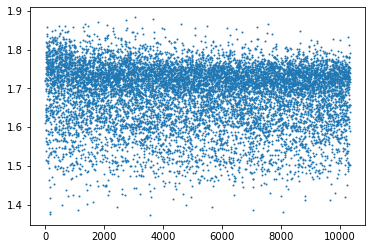

In [10]:
plt.scatter(range(len(path_)),[path_[k][1] for k in range(len(path_))],s=1)

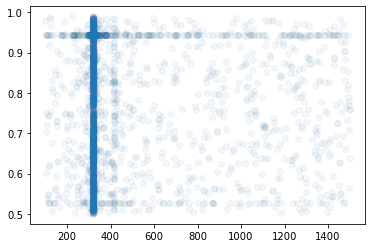

In [12]:
plt.scatter([path_[k][0][0] for k in range(len(path_))],[path_[k][0][1] for k in range(len(path_))],alpha=0.01)

In [13]:
np.argmin([path_[k][1] for k in range(len(path_))])

3543

In [14]:
path_[3543]

[array([354.43675516,   0.5507863 ]), 1.3736882427259036]

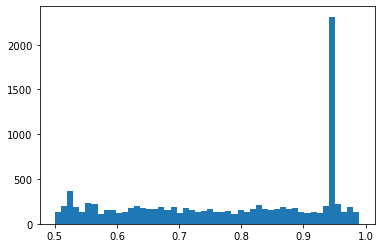

0.8074536846847398


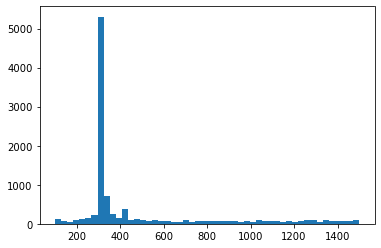

321.5548160742301


In [15]:
plt.hist([path_[k][0][1] for k in range(len(path_))],bins=50)
plt.show()
print(np.median([path_[k][0][1] for k in range(len(path_))]))
plt.hist([path_[k][0][0] for k in range(len(path_))],bins=50)
plt.show()
print(np.median([path_[k][0][0] for k in range(len(path_))]))

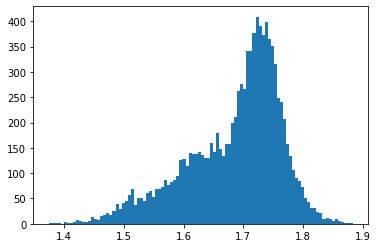

In [16]:
plt.hist([path_[k][1] for k in range(len(path_))],bins=100)
plt.show()

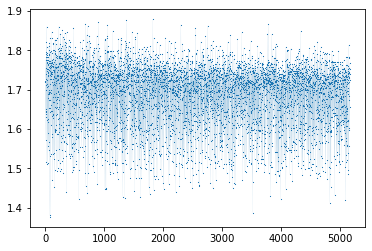

In [17]:
plt.plot([path_[2*k][1] for k in range(math.floor(len(path_)/2))],marker='x',markersize=0.5,linewidth=0.04)

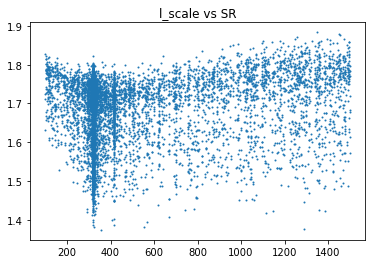

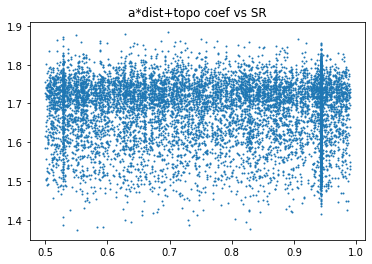

In [18]:
plt.scatter([path_[k][0][0] for k in range(len(path_))],[path_[k][1] for k in range(len(path_))],s=1)
plt.title('l_scale vs SR')
plt.show()
plt.scatter([path_[k][0][1] for k in range(len(path_))],[path_[k][1] for k in range(len(path_))],s=1)
plt.title('a*dist+topo coef vs SR')
plt.show()

In [21]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
knn.fit(np.array([path_[k][0] for k in range(len(path_))]))


NearestNeighbors(algorithm='ball_tree', n_neighbors=10)

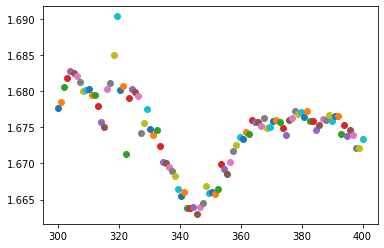

In [55]:
for l in np.linspace(300,400,100):
    plt.scatter(l,    np.mean([np.array([path_[g][1] for g in range(len(path_))])[c] for c in knn.kneighbors(np.array([[l,0.8]]),return_distance=False,n_neighbors=300)]))

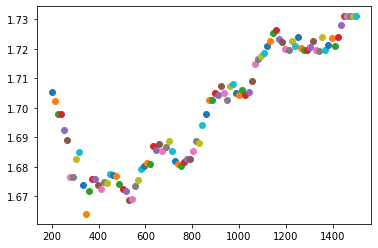

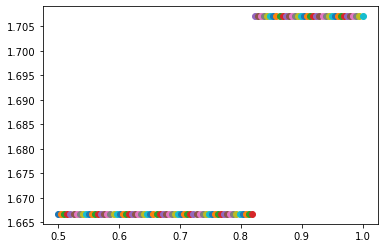

In [31]:
for l in np.linspace(200,1500,100):
    plt.scatter(l,np.mean([np.array([path_[g][1] for g in range(len(path_))])[c] for c in knn.kneighbors(np.array([[l,0.8]]),return_distance=False,n_neighbors=300)]))
plt.show()
for a in np.linspace(0.5,1,100):
    plt.scatter(a,np.mean([np.array([path_[g][1] for g in range(len(path_))])[c] for c in knn.kneighbors(np.array([[350,a]]),return_distance=False,n_neighbors=5)]))
plt.show()

In [34]:
l_scales = np.linspace(200,1500,50)
a_coefs = np.linspace(0.5,1,50)
L,A = np.meshgrid(l_scales,a_coefs)
Z=np.zeros(L.shape)
Z_variance=np.zeros(L.shape)
for l in tqdm(range(Z.shape[0])):
    for a in range(Z.shape[1]):
        Z[l,a] = np.mean([np.array([path_[k][1] for k in range(len(path_))])[k] for k in knn.kneighbors(np.array([[L[l,a],A[l,a]]]),return_distance=False,n_neighbors=300)])
        Z_variance[l,a] = np.std([np.array([path_[k][1] for k in range(len(path_))])[k] for k in knn.kneighbors(np.array([[L[l,a],A[l,a]]]),return_distance=False,n_neighbors=300)])

100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


C:\Users\u1819911\AppData\Local\Temp\ipykernel_5544\2429028248.py:1: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contourf(L,A,Z,25,color='viridis')


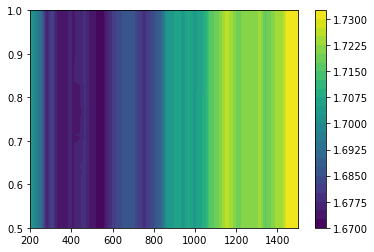

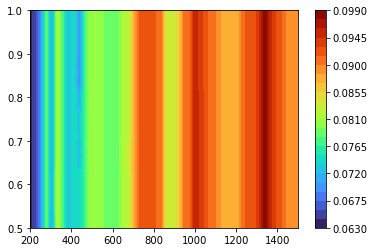

In [35]:
plt.contourf(L,A,Z,25,color='viridis')
plt.colorbar()
plt.show()
plt.contourf(L,A,Z_variance,25,cmap='turbo')
plt.colorbar()

C:\Users\u1819911\AppData\Local\Temp\ipykernel_10512\507829712.py:3: UserWarning: linewidths is ignored by contourf
  plt.tricontourf([path_[k][0][0] for k in range(len(path_))], [path_[k][0][1] for k in range(len(path_))], [path_[k][1] for k in range(len(path_))], levels=100, linewidths=0.5,cmap='viridis_r')


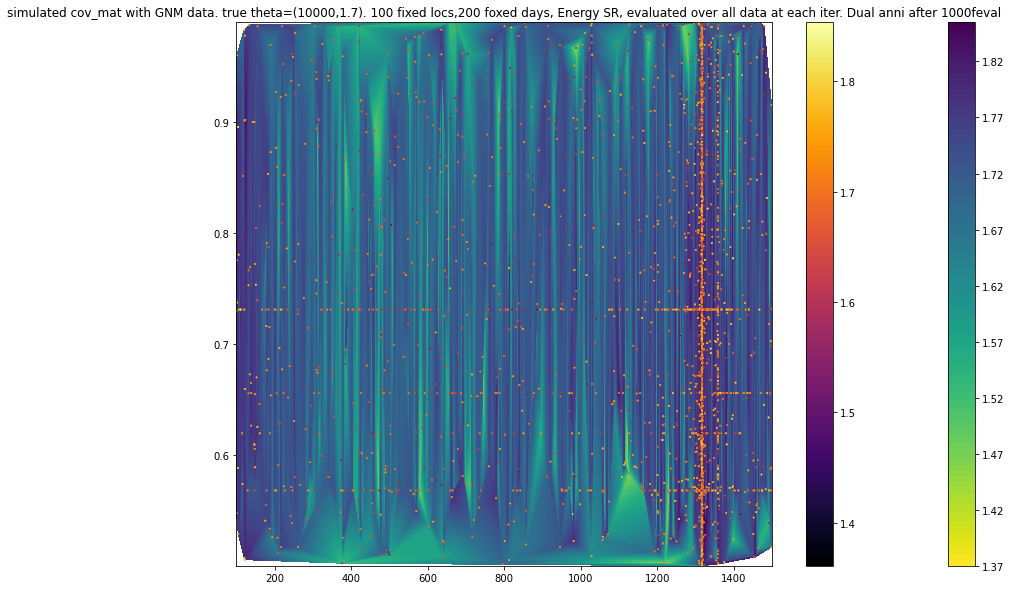

In [25]:
fig = plt.gcf() 
fig.set_size_inches(15,10)
plt.tricontourf([path_[k][0][0] for k in range(len(path_))], [path_[k][0][1] for k in range(len(path_))], [path_[k][1] for k in range(len(path_))], levels=100, linewidths=0.5,cmap='viridis_r')
plt.colorbar()
plt.scatter([path_[k][0][0] for k in range(len(path_))], [path_[k][0][1] for k in range(len(path_))], c=[path_[k][1] for k in range(len(path_))],s=0.5,cmap='inferno')
plt.colorbar()
plt.title('simulated cov_mat with GNM data. true theta=(10000,1.7). 100 fixed locs,200 foxed days, Energy SR, evaluated over all data at each iter. Dual anni after 1000feval')
plt.show()

In [26]:
len(np.argwhere(np.array([path_[k][1] for k in range(len(path_))])<1.5).flatten()
)

493

C:\Users\u1819911\AppData\Local\Temp\ipykernel_10512\2609435123.py:4: UserWarning: linewidths is ignored by contourf
  plt.tricontourf([path_[k][0][0] for k in idx_over6_5_SR], [path_[k][0][1] for k in idx_over6_5_SR], [path_[k][1] for k in idx_over6_5_SR], levels=100, linewidths=0.5,cmap='viridis_r')


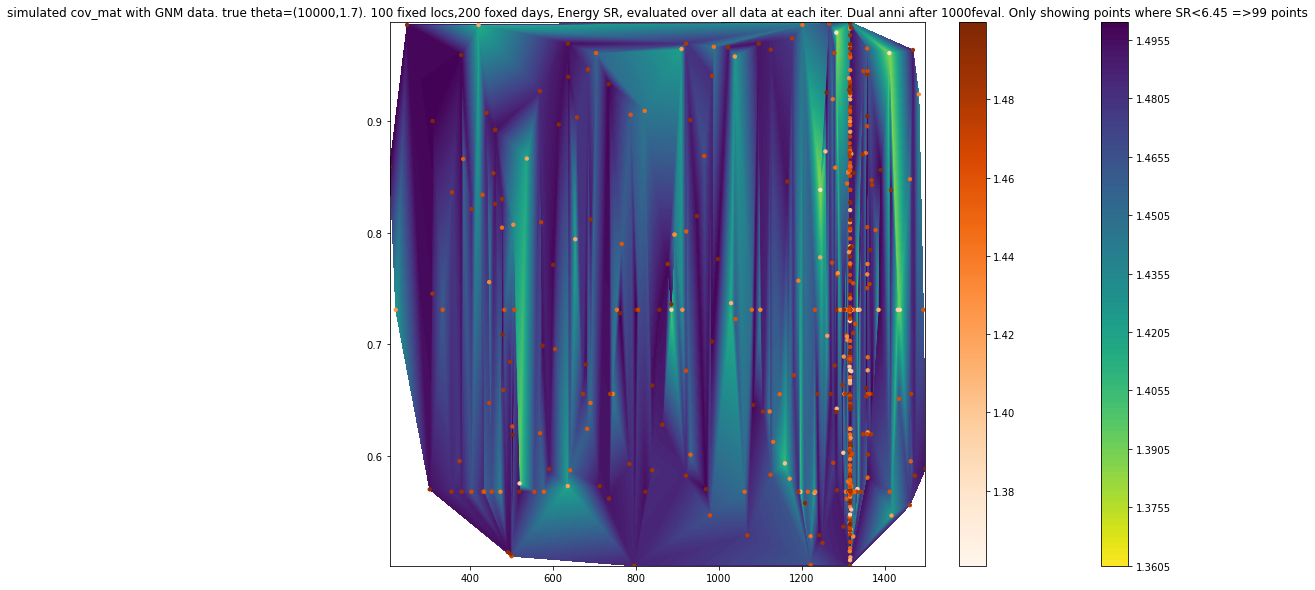

In [27]:
idx_over6_5_SR = np.argwhere(np.array([path_[k][1] for k in range(len(path_))])<1.5).flatten()
fig = plt.gcf() 
fig.set_size_inches(15,10)
plt.tricontourf([path_[k][0][0] for k in idx_over6_5_SR], [path_[k][0][1] for k in idx_over6_5_SR], [path_[k][1] for k in idx_over6_5_SR], levels=100, linewidths=0.5,cmap='viridis_r')
plt.colorbar()
plt.scatter([path_[k][0][0] for k in idx_over6_5_SR], [path_[k][0][1] for k in idx_over6_5_SR], c=[path_[k][1] for k in idx_over6_5_SR],s=11,cmap='Oranges')
plt.colorbar()
plt.title('simulated cov_mat with GNM data. true theta=(10000,1.7). 100 fixed locs,200 foxed days, Energy SR, evaluated over all data at each iter. Dual anni after 1000feval. Only showing points where SR<6.45 =>99 points')
plt.show()

### Experiments for SR estimation

In [59]:
subset_locations = []
def generate_subsample_locs(locs_nb):
    locs=[]
    while len(locs)<locs_nb:
        random_center = np.random.choice(range(len(GNM_landonly))) 
        locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<(np.sqrt(locs_nb/np.pi)+3) for k in range(len(GNM_landonly))])[0]
    return np.random.choice(locs,size=locs_nb,replace=False)    
for s in range(50):
    subset_locations.append(generate_subsample_locs(locs_nb=200))

In [64]:
def Spatial_Energy_Score_sublocs(theta,beta,sub_locs,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix=None):
    '''
    theta: vector of 3 [Matern_param, coef_distmat, coef_topomat]. The coefs are applied to the matricies to form the ditance matrix used as input in the Matern kernel to form the covariance.
    sub_locs: a set of subsets of location indexes with the same number of locs in each.
    days_nb: how many days to include on the subsample.
    sim_nb: number of simulation draws to compare with original data in the score.
    observations_x: x, observed rainfall transformed to a Gaussian normal scale. This is the data that we try to emulate.
    censor_levels_di: d, probability of no rain (1-p) transformed to a normal scale. These are used to censor simulations (x') when comparingt to x.
    '''
    # Subsample locations. Choose a random subset the list of subsets - sub_locs.
    locs = sub_locs[np.random.choice(range(len(sub_locs)))] 
    locs_nb = len(locs)
    # Subsample days.
    days = np.random.choice(range(len(observations_x)),size=days_nb,replace=False)

    # Select relevant subsamples of data.
    x = observations_x[days,:][:,locs]
    d = censor_levels_di[days,:][:,locs]
    
    # Create covariance matrix.
    if np.sum(topo_matrix==None):
        cov_mat = np.nan_to_num(Matern(length_scale=theta,nu=3.5).__call__(dist_matrix[locs,:][:,locs]))
    else:
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(theta[1]*dist_mat[locs,:][:,locs]+((1-theta[1])/70)*topo_dist[locs,:][:,locs]))

    # Draw samples from the multivariate nromal with appropriate covariance.
    simulations = scs.multivariate_normal(mean=np.zeros(locs_nb),cov=cov_mat,allow_singular=True).rvs(size=sim_nb)
    
    # Censor simulated values and format them into [[sim0-day0,sim0-day1,...,sim0-dayn] ,..., [sim_m-day0,sim_m-day1,...,sim_m-dayn]]. Gives sim_nb*days_nb=m*n vectors of len=locs_nb. 
    censored_sims = np.maximum(np.repeat(simulations,days_nb,axis=0),np.tile(d,(sim_nb,1)))

    # ||x' - x' ||_2 component of energy score
    sims_by_day = [censored_sims[0+k::days_nb] for k in range(days_nb)] # regroup to get [[sim(1,day1), sim(2,day1),...,sim(m,day1)],...,[sim(1,dayn), sim(2,dayn),...,sim(m,dayn)]].
    
    sim_L2_diff = 0
    
    for sim_day_i in sims_by_day: # don't know how to make it more efficient... maybe can parallelize to compute complete score
        
        # ||x' - x' ||_2 component of energy score
            # OLD: einsum from Lorenzos code on each sim_day_i was 9x slower then doing pdist on each sim_day_i. Both give the same answer
        '''
        # matrix of all combinations over i of [vector_i-vector_1, ... , vector_i-vector_n]
        temp_diff_combinations_matrix = sim_day_i.reshape(1,sim_nb,locs_nb)-sim_day_i.reshape(sim_nb,1,locs_nb) 
        # einsum creates a matrix of sum of squares, then take sqrt to get L2.
        sim_L2_diff+=0.5*np.sum(np.sqrt(np.einsum('ijk, ijk -> ij',temp_diff_combinations_matrix,temp_diff_combinations_matrix))) 
        '''
            # New: pdist takes the offdiagonal of an L2 distance matrix, only counting once each combination of Y,Y'.
        sim_L2_diff+= 2 * np.sum(np.power(pdist(sim_day_i),beta))

    # Add both parts of Energy.
    Energy = 2 * np.mean(np.power(np.linalg.norm(censored_sims - np.tile(x,(sim_nb,1)),axis=1),beta)) - sim_L2_diff/(days_nb*sim_nb*(sim_nb-1))
    
    
    path_.append([theta,Energy])
    print([theta,Energy])

    return Energy

path_avg = []

def Spatial_Energy_Score_sublocs_averaged(theta,beta,sub_locs,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix,avg_nb):
    avg_SR = 0

    for s in range(avg_nb):
        avg_SR+= Spatial_Energy_Score_sublocs(theta,beta,sub_locs,days_nb,sim_nb,observations_x,censor_levels_di,dist_matrix,topo_matrix)

    path_avg.append(avg_SR/avg_nb)
    
    return avg_SR/avg_nb

In [63]:
# Generating fake data

# 1 - fixing a theta and generating data from that, then estimating to retrieve the same theta.
def generate_subsample_locs(location_number):
    l=[]
    while len(l)<location_number:
        random_center = np.random.choice(range(len(GNM_landonly))) 
        l = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<(np.sqrt(location_number/np.pi)+30) for k in range(len(GNM_landonly))])[0]
    return np.random.choice(l,size=location_number,replace=False)    

subset_locations = []
for s in range(250):
    subset_locations.append(generate_subsample_locs(location_number=800))

fake_locs=range(len(GNM_landonly))
fake_theta = [450,0.9]
fake_cov_mat =np.nan_to_num(Matern(length_scale=fake_theta[0],nu=3.5).__call__(fake_theta[1]*dist_mat+((1-fake_theta[1])/70)*topo_dist)) 
fake_data = scs.multivariate_normal(mean=np.zeros(len(fake_locs)),cov=fake_cov_mat,allow_singular=True).rvs(size=5000)
for day,day_data in enumerate(fake_data):
    fake_data[day]=np.maximum(day_data,[censor_levels_di[day][l] for l in fake_locs])
fake_censor_levels_di = censor_levels_di[fake_locs,:][:,fake_locs]


In [65]:
# 100 sets of 800 locs, 700 days, 150 sims, beta=0.2 , avg of 4 =>25s/SRavg
path_=[]
path_avg = []
Spatial_Energy_Score_sublocs_averaged(theta=[800,0.9],
                                      beta=0.2, 
                                      sub_locs=subset_locations, 
                                      days_nb=700,sim_nb=150, 
                                      observations_x=fake_data, 
                                      censor_levels_di=censor_levels_di, 
                                      dist_matrix=dist_mat,
                                      topo_matrix=topo_dist,
                                      avg_nb=4)

[[800, 0.9], 1.864289598370574]
[[800, 0.9], 1.8738478355368884]
[[800, 0.9], 1.8902209363094606]
[[800, 0.9], 1.8225502104545563]


1.86272714516787

In [57]:
qqq=[[],[]]
for a in tqdm(range(20)):
    qqq[1].append(Spatial_Energy_Score_sublocs(theta=[30000,3],beta=0.2,sub_locs=subset_locations,days_nb=700,sim_nb=100,observations_x=fake_data,censor_levels_di=censor_levels_di,dist_matrix=dist_mat,topo_matrix=topo_dist)
)
    qqq[0].append(Spatial_Energy_Score_sublocs(theta=[100,4],beta=0.2,sub_locs=subset_locations,days_nb=700,sim_nb=100,observations_x=fake_data,censor_levels_di=censor_levels_di,dist_matrix=dist_mat,topo_matrix=topo_dist)
)
plt.plot(qqq[0])
plt.plot(qqq[1],color='red')
np.mean(np.array(qqq),axis=1) # 750 locations 700 days 100 sims, beta = 0.2

100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


In [69]:
path_ = []

dual_annealing(Spatial_Energy_Score_sublocs_averaged,[(100,1500),(0.5,0.99)],args=(0.2,subset_locations,700,150,fake_data,censor_levels_di,dist_mat,topo_dist,4),no_local_search=True,maxiter=13000)

[array([1.32971775e+03, 6.25191128e-01]), 1.9269612187393046]
[array([1.32971775e+03, 6.25191128e-01]), 1.9193249776595551]
[array([1.32971775e+03, 6.25191128e-01]), 1.8654244392648476]
[array([1.32971775e+03, 6.25191128e-01]), 1.9160284001724175]
[array([424.87221506,   0.59965793]), 1.830505126281224]
[array([424.87221506,   0.59965793]), 1.839348827028412]
[array([424.87221506,   0.59965793]), 1.804638981704336]
[array([424.87221506,   0.59965793]), 1.746164947378585]
[array([520.8108747 ,   0.98831758]), 1.7424047014206012]
[array([520.8108747 ,   0.98831758]), 1.8326020720233602]
[array([520.8108747 ,   0.98831758]), 1.789826901643535]
[array([520.8108747 ,   0.98831758]), 1.8220379830631905]
[array([733.6532135 ,   0.98831758]), 1.8604624592966503]
[array([733.6532135 ,   0.98831758]), 1.8790867864903953]
[array([733.6532135 ,   0.98831758]), 1.867302417547166]
[array([733.6532135 ,   0.98831758]), 1.9194773936821206]
[array([7.33653214e+02, 5.87834676e-01]), 1.872435306730835]
[

### Estimation with MLE

In [480]:
# Define functions manually
import numpy as np
import scipy.stats as scs
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics.pairwise import rbf_kernel as rbf

def mvn_cdf(a,b,Sigma):
    m = len(a)
    # Reorder Sigma, a and b according to the length of interval (higher earlier)
    len_interval = np.zeros(m)
    for ind in range(m):
        if a[ind] == -np.inf:
            a[ind] = -100000
        if b[ind] == np.inf:
            b[ind] = 100000
        len_interval[ind] = b[ind] - a[ind]
    order_len_interval = [int(i[0]) for i in sorted(enumerate(len_interval), key=lambda x:x[1], reverse=True)]
    Sigma = Sigma[order_len_interval, :][:,order_len_interval]
    a = [a[x] for x in order_len_interval]
    b = [b[x] for x in order_len_interval]


    d = np.zeros(shape=(m,))
    e = np.ones(shape=(m,))
    f = np.zeros(shape=(m,))
    y = np.zeros(shape=(m,))
    # these can be changed for different precision levels
    epsilon = 1.e-3
    alpha = 2.5
    N_max = int(1e2)

    # Compute Cholesky decomposition of Sigma to produce lower trinagualr matrix
    C = np.linalg.cholesky(Sigma)

    #Sigma_sparse = sparse.csc_matrix(Sigma)
    #C_sparse = cholmod.cholesky(Sigma_sparse).L()
    #C = C_sparse

    Intsum, N, Varsum = 0, 0, 0

    if a[0] != -np.inf:
        d[0] = scs.norm.cdf(a[0]/C[0,0])
    if b[0] != np.inf:
        e[0] = scs.norm.cdf(b[0]/C[0,0])
    f[0] = np.log(e[0] - d[0])

    for ind_N in range(N_max):
        
        w = np.random.rand(m)
        for ind_m in range(1,m):
            y[ind_m-1] = scs.norm.ppf(d[ind_m-1]+w[ind_m-1]*(e[ind_m-1]-d[ind_m-1]))
            if a[ind_m] != -np.inf:
                d[ind_m] = scs.norm.cdf((a[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            if b[ind_m] != np.inf:
                e[ind_m] = scs.norm.cdf((b[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            f[ind_m] = np.log((e[ind_m] - d[ind_m])) + f[ind_m-1]
        N = N+1
        delta = (f[-1]-Intsum)/N
        Intsum = Intsum + delta
        Varsum = (N-2)*Varsum/N + pow(delta, 2)
        Error = alpha*np.sqrt(Varsum)
        if Error < epsilon:
            break

    return(Intsum)

# Truncated Gaussian copula
class truncgauss_():
    def __init__(self,L,path):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
        self.path=path
    
    def sim(self,theta,inv_ps,draws,day_idx,topo,kernel='rbf',method='multiply',rvs=None,give_rvs=None):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        if rvs==None:
            # Generate mvn with cov_mat, then censor according to p_i
            n = len(self.L)
            # covariance matrix based on kernel
            if method=='multiply':
                if kernel =='rbf':
                    cov_mat = np.multiply(rbf(self.L,gamma=theta[0]),rbf(topo,gamma=theta[1]))
                elif kernel == 'Matern':
                    cov_mat = np.multiply(Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L),Matern(length_scale=theta[2],nu=theta[3]).__call__(topo))
            elif method=='add':
                if kernel =='rbf':
                    cov_mat = np.add(rbf(self.L,gamma=theta[0]),rbf(topo,gamma=theta[1]))/2
                elif kernel == 'Matern':
                    cov_mat = np.add(Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L),Matern(length_scale=theta[2],nu=theta[3]).__call__(topo))/2
            # n draws of corresponding normal values
            rvs = scs.multivariate_normal.rvs(np.zeros(n),np.nan_to_num(cov_mat),size=draws)
            if give_rvs!=None:
                return rvs

        # turn into cdf values, and censor based on inv_u
        return  [[ scs.norm.cdf(max(rvs[i][j],-inv_ps[day_idx][j])) for j in range(n)] for i in range(draws)]
    
    def nll_Matern(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs):
        '''
        theta: parameters for kernels of distance and topography. Matern->2+2 parameters.
        Invcdf_Us: ppf_norm(cdf_GNM(observations)). Invcdf_Us are observed rain values transformed to represent a 0-centered standart gaussian.
        truncation_pi: p parameter values.
        did_rain: vector of 0/1 for indicating rain. 0->rain 1->no rain.
        len_locs: number of locations.
        topo: matrix of topology distances between all locations. Has to correspond to the location distances matrix used to initiate the truncgauss class.

        Number of days to compute nll for is given by the length of Invcdf_Us. 
        Everything is querried based on the dimensions of Invcdf_Us, so better to have them come from the same day/locatoins combination.
        '''
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L))
        nll=0
        plt.matshow(cov_mat)
        plt.colorbar()
        plt.show()
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            
            else: # some dry -> use elegant cdf
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else: # not all dry
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    
                    #### New estimate part ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do new approximation to cdf
                    nll += mvn_cdf(np.repeat(-np.inf,len(c_dry)),[Invcdf_Us[day][k] for k in c_dry],np.round(sub_cov,6))                               

                    #### New estimate part - end ####

            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_Matern_add_scs_norm(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,topo,coef):
        '''
        theta: parameters for kernels of distance and topography. Matern->2+2 parameters.
        Invcdf_Us: ppf_norm(cdf_GNM(observations)). Invcdf_Us are observed rain values transformed to represent a 0-centered standart gaussian.
        truncation_pi: p parameter values.
        did_rain: vector of 0/1 for indicating rain. 0->rain 1->no rain.
        len_locs: number of locations.
        topo: matrix of topology distances between all locations. Has to correspond to the location distances matrix used to initiate the truncgauss class.

        Number of days to compute nll for is given by the length of Invcdf_Us. 
        Everything is querried based on the dimensions of Invcdf_Us, so better to have them come from the same day/locatoins combination.
        '''
        cov_mat = np.nan_to_num(coef*Matern(length_scale=theta[0],nu=3.5).__call__(self.L)+(1-coef)*Matern(length_scale=theta[1],nu=3.5).__call__(topo))
        nll=0

        for day in range(len(Invcdf_Us)): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            
            else: # some dry -> use elegant cdf
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else: # not all dry
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    
                    #### New estimate part ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do new approximation to cdf
                    nll += scs.multivariate_normal(mean=np.zeros(len(sub_cov)),cov=sub_cov).cdf([Invcdf_Us[day][k] for k in c_dry])                                       

                    #### New estimate part - end ####

            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
        #self.path.append([theta,-nll])
        print([theta,coef,-nll])
        return -nll




In [484]:
path_ = []
def nll_opti_add_scs_norm(theta): # 14 hours to run 117 * 50loc * 100days, 15s for 9loc*100days, 1m for 9locs*400days
    days = np.random.choice(range(5173),size=30,replace=False)
    out_ = []
    for stoch_est in range(5):
        random_center = np.random.choice(range(4087)) 
        locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<2 for k in range(4087)])[0] 

        out_.append(
        truncgauss_(dist_mat[locs,:][:,locs],path_).nll_Matern_add_scs_norm(
        theta=[theta[0],theta[1]],
        Invcdf_Us=[scs.norm.ppf(scs.gamma(a=1/np.array([GNM_landonly[l][1][d] for l in locs]),scale=np.multiply(np.array([GNM_landonly[l][1][d] for l in locs]),np.array([GNM_landonly[l][0][d] for l in locs]))).cdf(5)) for d in days],
        truncation_pi=[[GNM_landonly[l][4][d] for l in locs] for d in days],
        did_rain=[[GNM_landonly[l][2][d] for l in locs] for d in days],
        len_locs=len(locs),
        topo=topo_dist[locs,:][:,locs],  
        coef=theta[2]))

    path_.append(np.mean(out_))
    return np.mean(out_)
#nll_opti_add_scs_norm([300,5000,0.7])

def opti(coef):
    return nll_opti_add_scs_norm([208.33527405079707, 4500.926059535104,coef])
opti(0.7)

KeyboardInterrupt: 

In [486]:
path_ = []+5
dual_annealing(opti,[(0.1,0.9)]) #6k iter, [[51.41723789198021, 3.5, 998.6415057521112, 3.5], -468.5687165591668], at bounds [(30,1000),(30,1000)] , 9 locs, 30 days, 10* stoch estimate avg returned

[[208.33527405079707, 4500.926059535104], array([0.55430336]), -90.70788588126024]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), 637.3491670701461]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), -256.4604726842905]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), 175.3762497423552]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), -344.5881225169336]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), -373.1267052605836]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), 53.70020456056618]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), -353.25423414249593]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), 650.6841893446282]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), -374.13429929632747]
[[208.33527405079707, 4500.926059535104], array([0.17026522]), -161.64477863949725]
[[208.33527405079707, 4500.926059535104], array([0.17026522]), -199.21415766082225]
[[20

KeyboardInterrupt: 

### Simulation

In [52]:
#cov_rain = np.cov(np.transpose(obs_norm_all))
#sim_cov_rain = scs.multivariate_normal(mean=np.zeros(len(dist_mat)),cov=cov_rain).rvs(size=25)
theta = [520,0.85] 
sim_test = scs.multivariate_normal(mean=np.zeros(len(dist_mat)),cov= np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(theta[1]*dist_mat+((1-theta[1])/70)*topo_dist)) ,allow_singular=True).rvs(size=500)

#theta2 = [310, 1] 
#sim_test2 = scs.multivariate_normal(mean=np.zeros(len(dist_mat)),cov= np.nan_to_num(Matern(length_scale=theta2[0],nu=3.5).__call__(theta[1]*dist_mat+((1-theta[1])/70)*topo_dist)) ,allow_singular=True).rvs(size=25)

In [46]:
def GNM_ppf(x_one_day_all_locs,day_idx):
    m = np.array([GNM_landonly[l][0][day_idx] for l in range(len(x_one_day_all_locs))])
    d = np.array([GNM_landonly[l][1][day_idx] for l in range(len(x_one_day_all_locs))])
    p = np.array([GNM_landonly[l][4][day_idx] for l in range(len(x_one_day_all_locs))])
    sim_u = scs.norm.cdf(x_one_day_all_locs)
    censored_u = (sim_u+p-1)/p
    return np.nan_to_num(scs.gamma(a=1/d,scale=m*d).ppf(censored_u),nan=0)
    

#GNM_landonly[location][param][day]


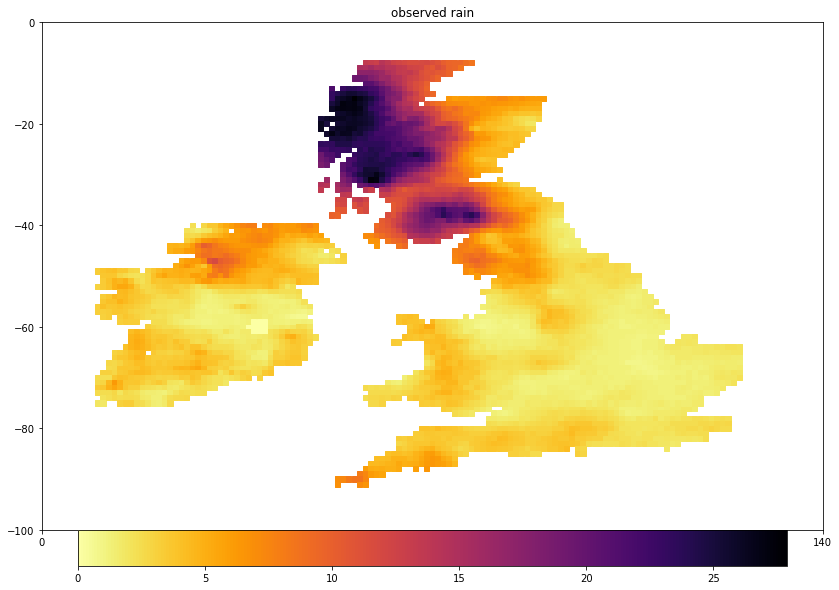

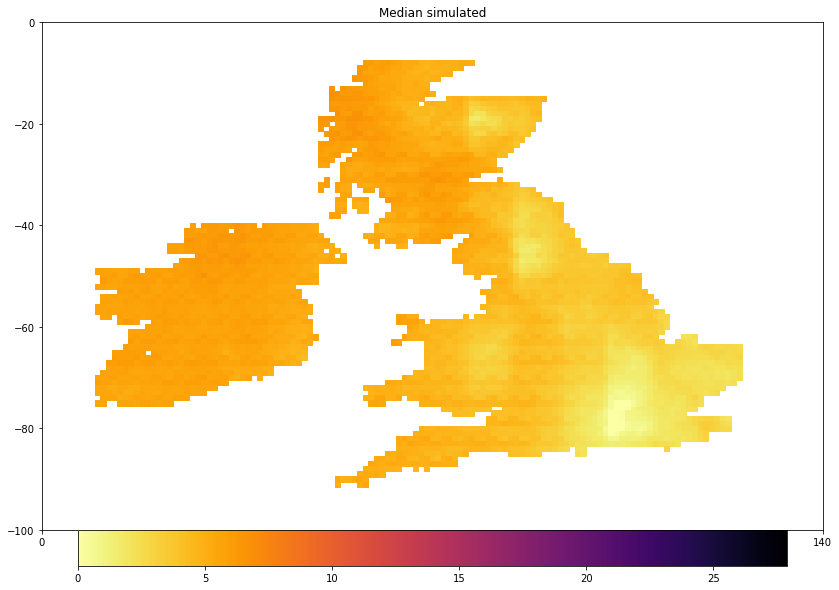

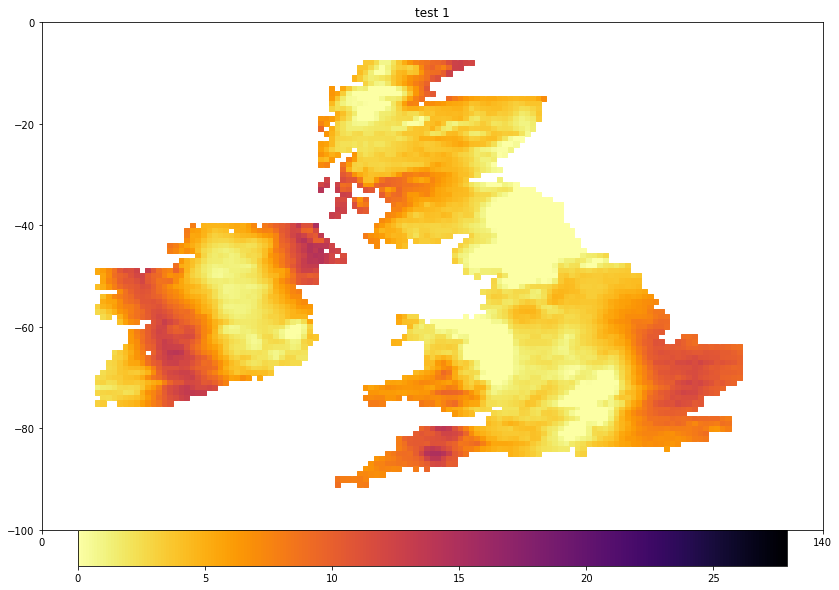

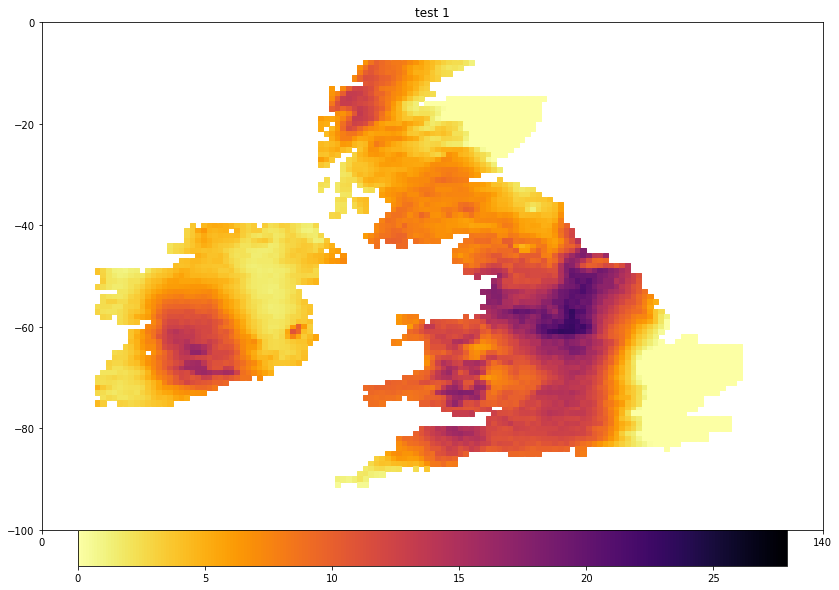

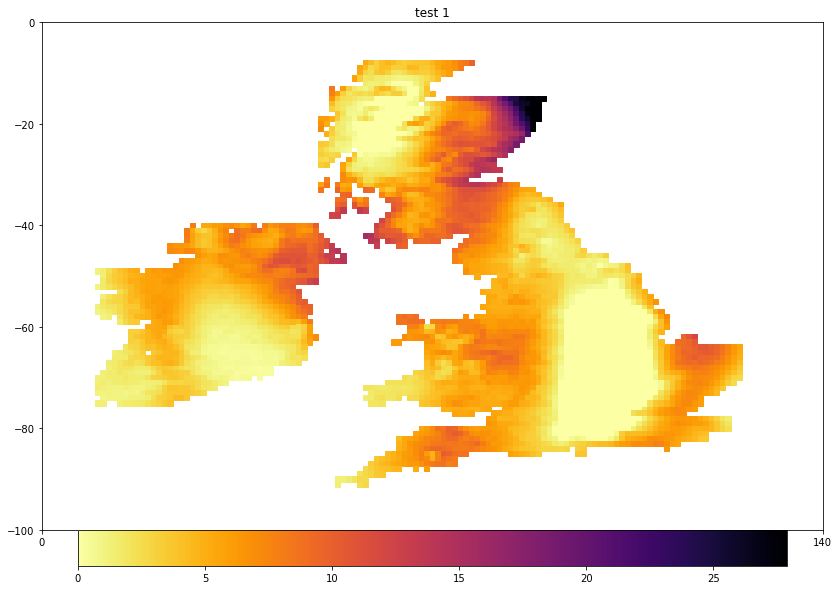

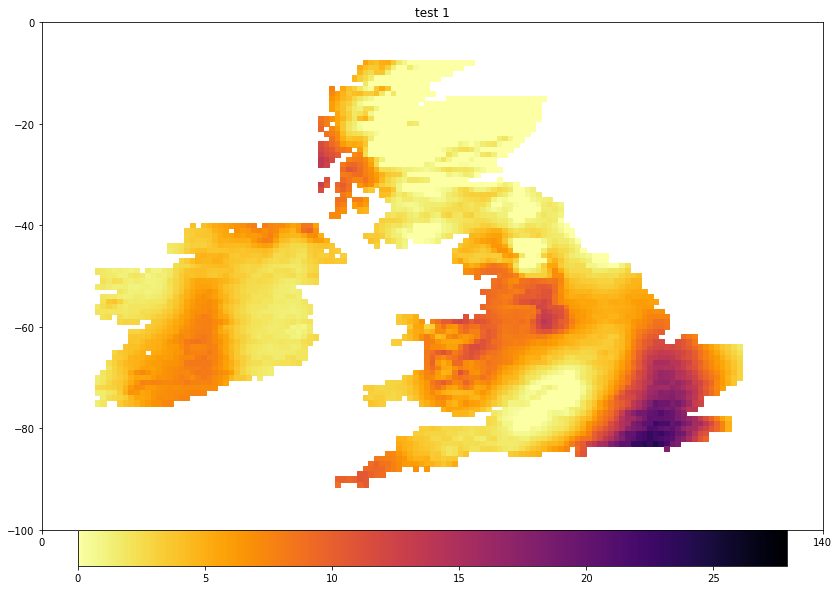

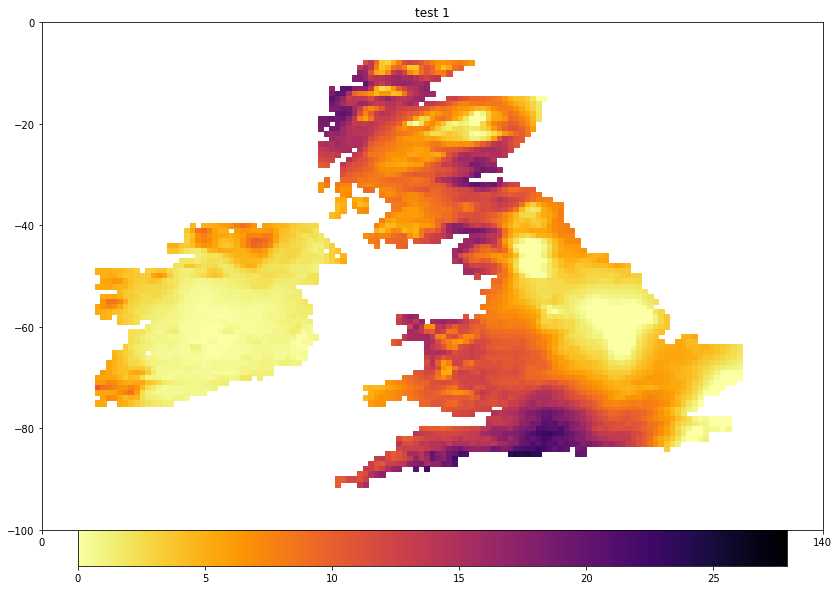

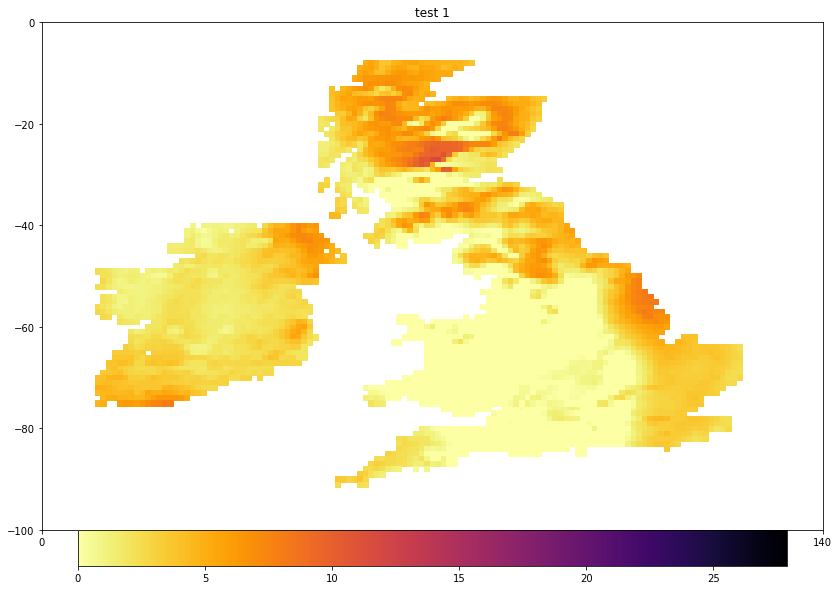

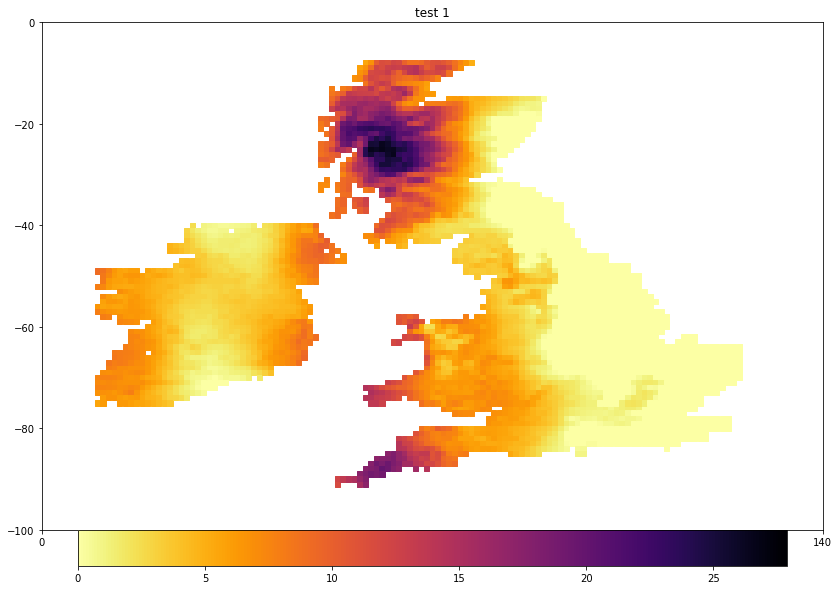

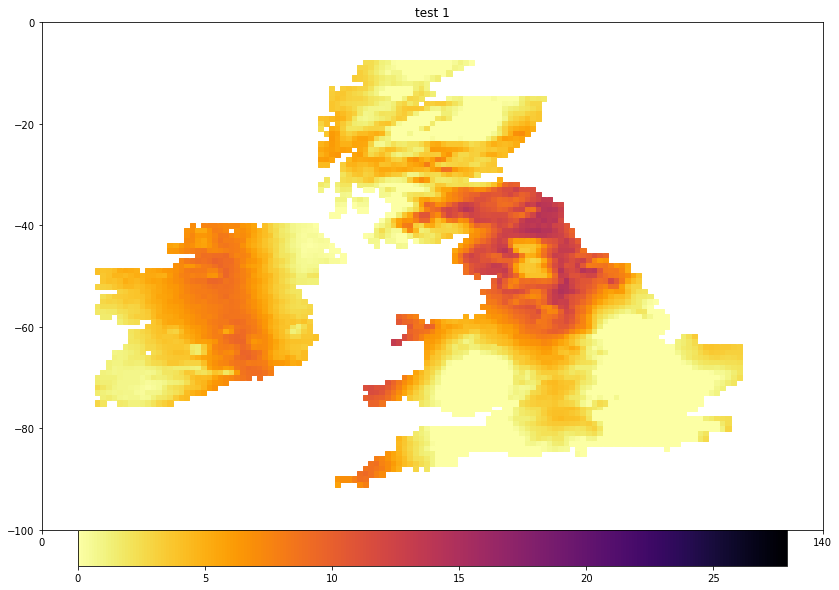

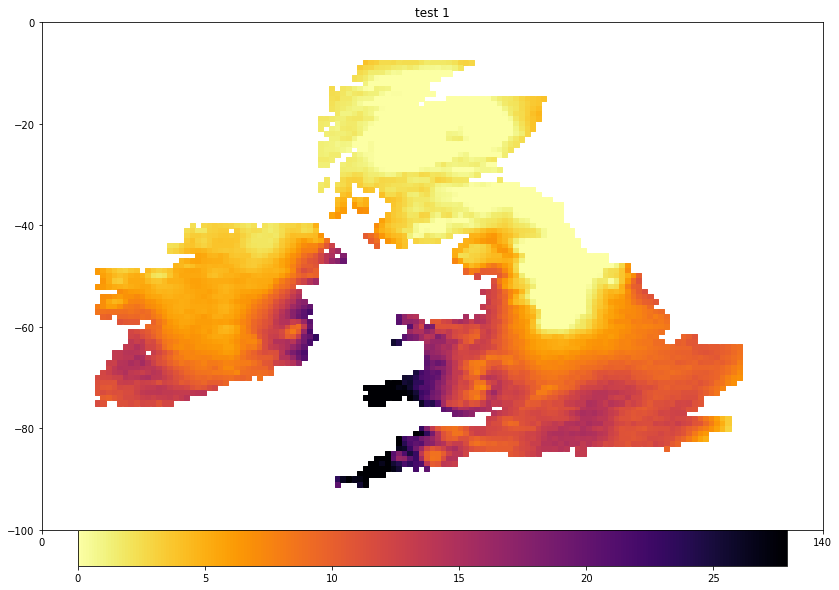

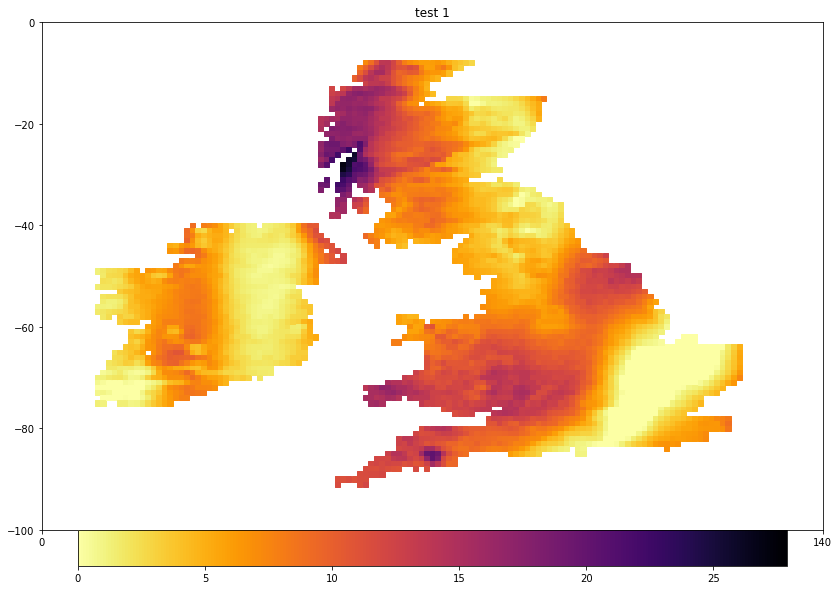

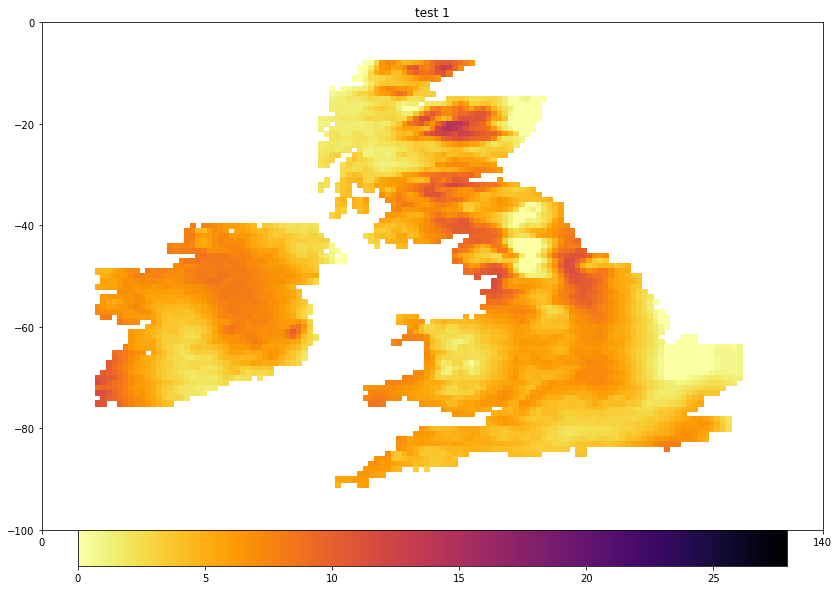

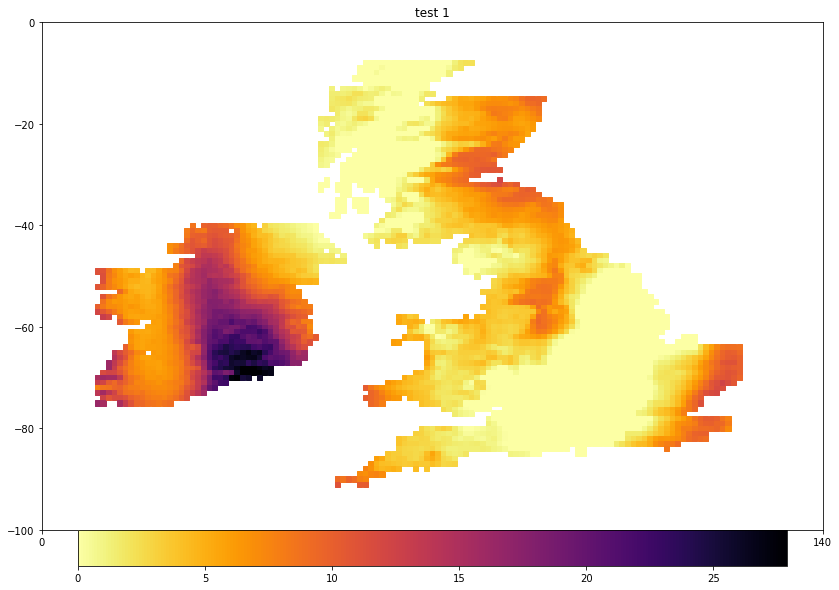

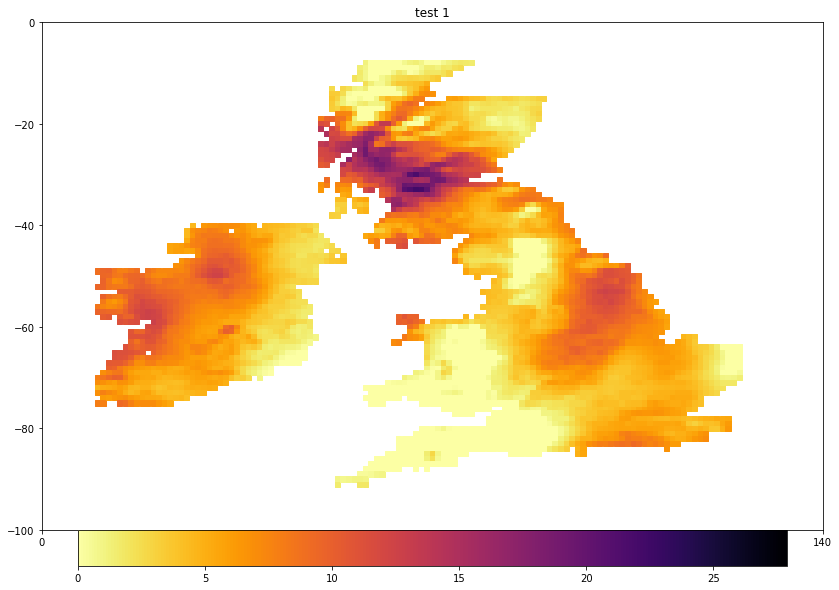

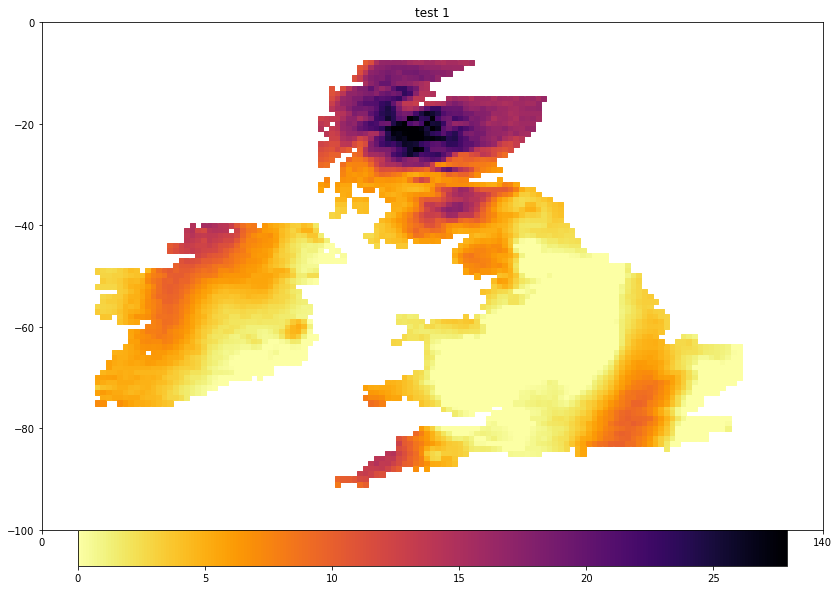

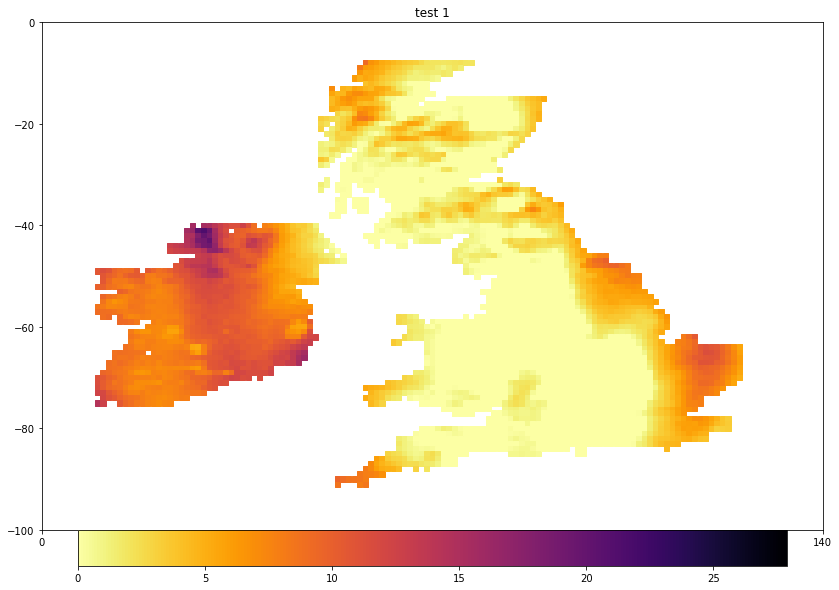

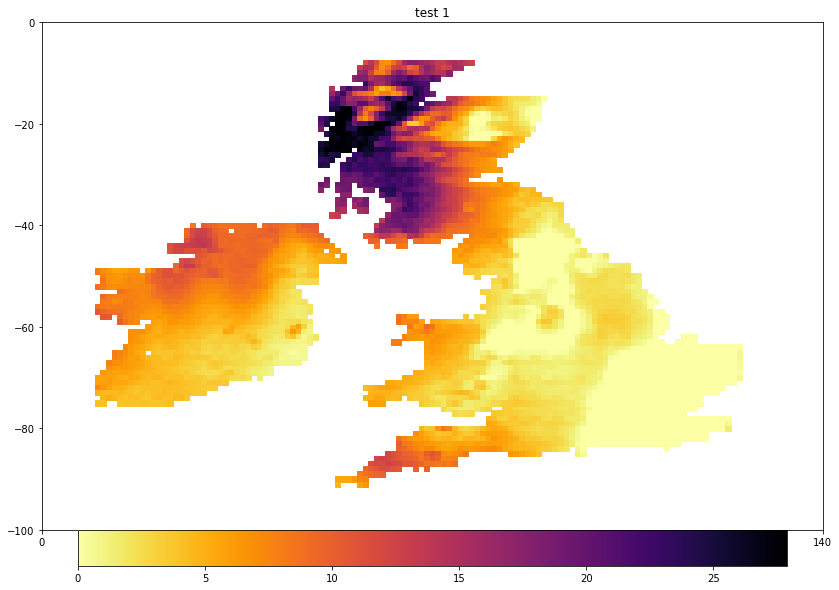

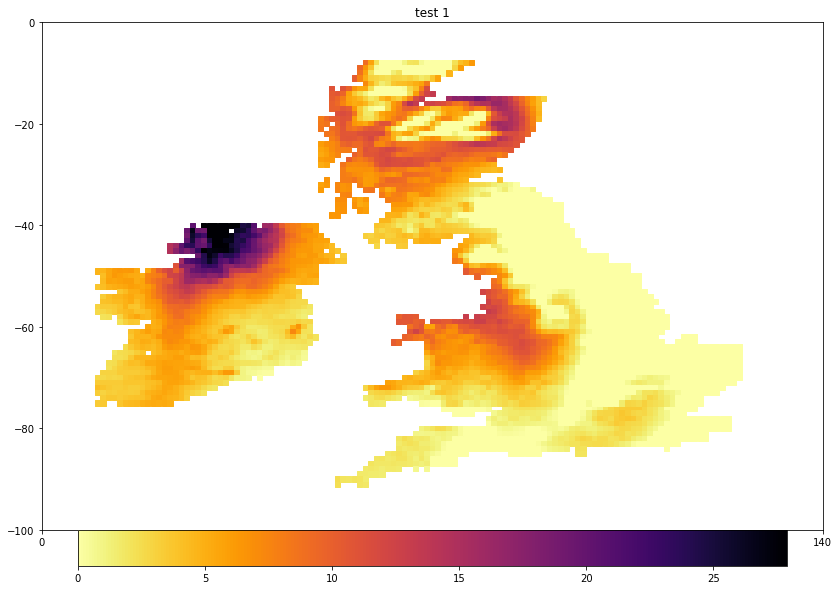

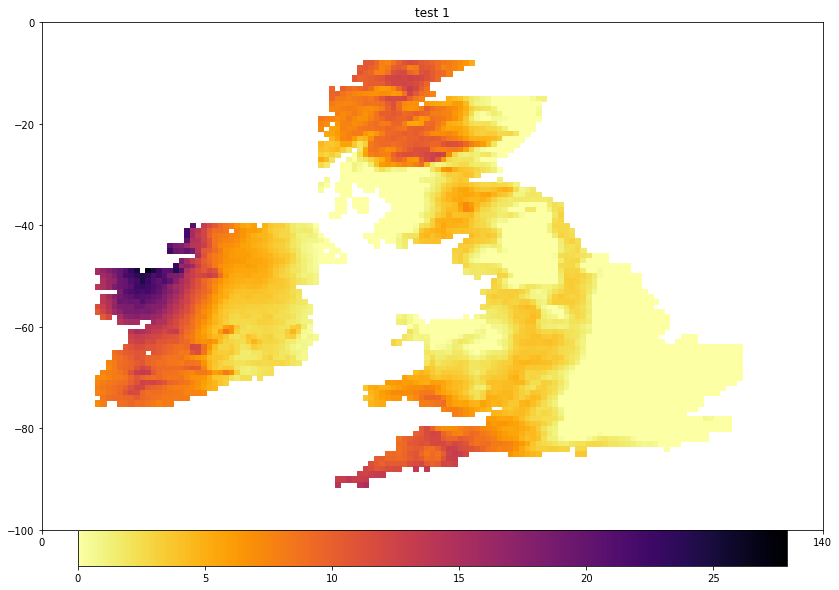

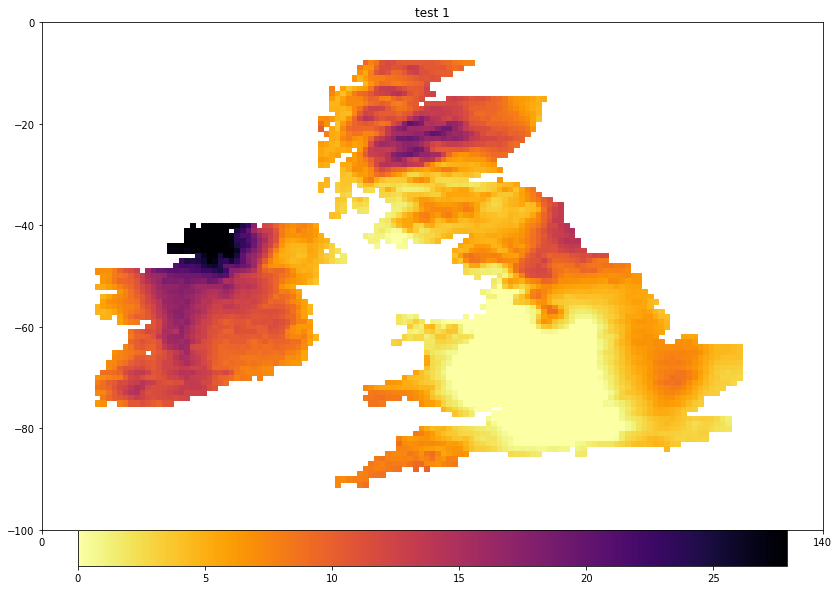

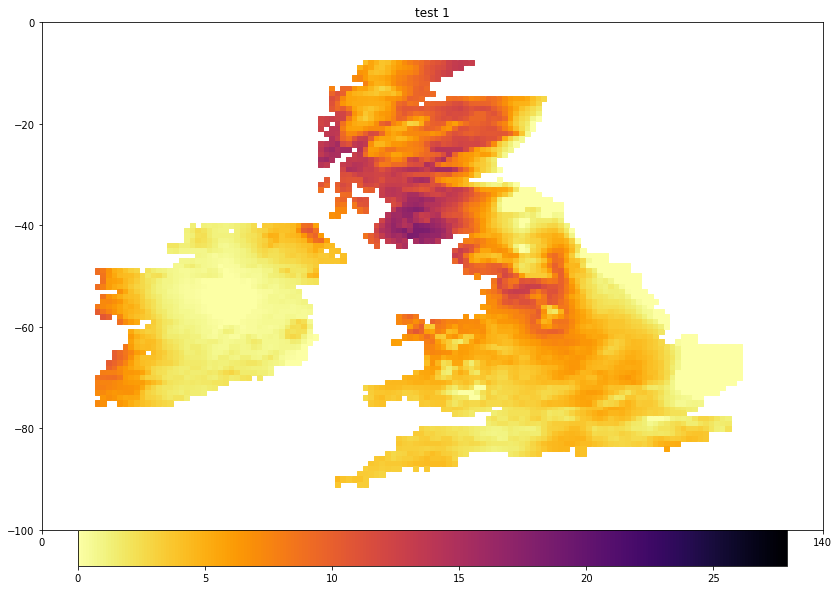

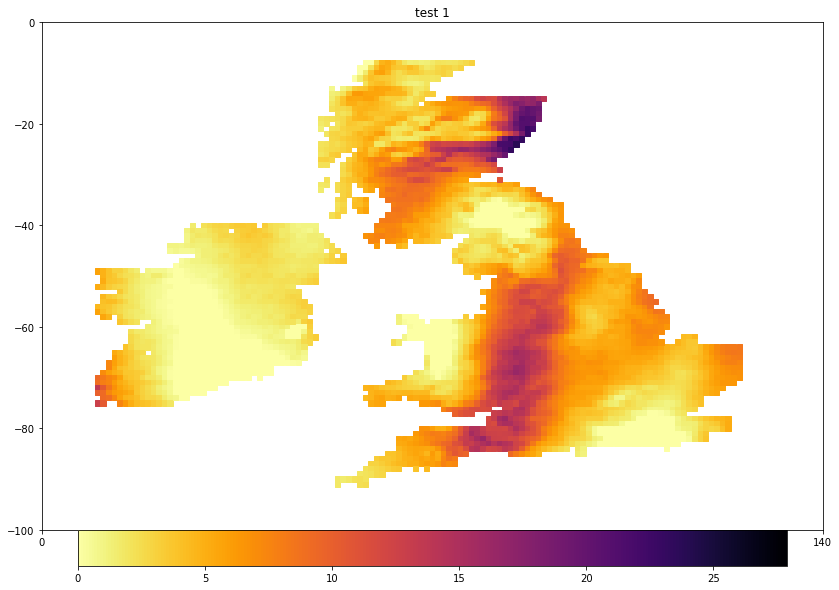

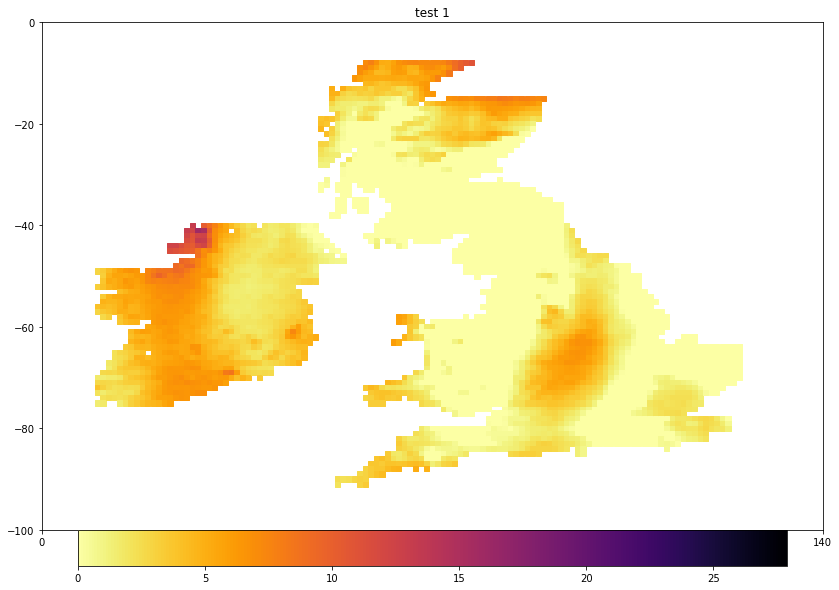

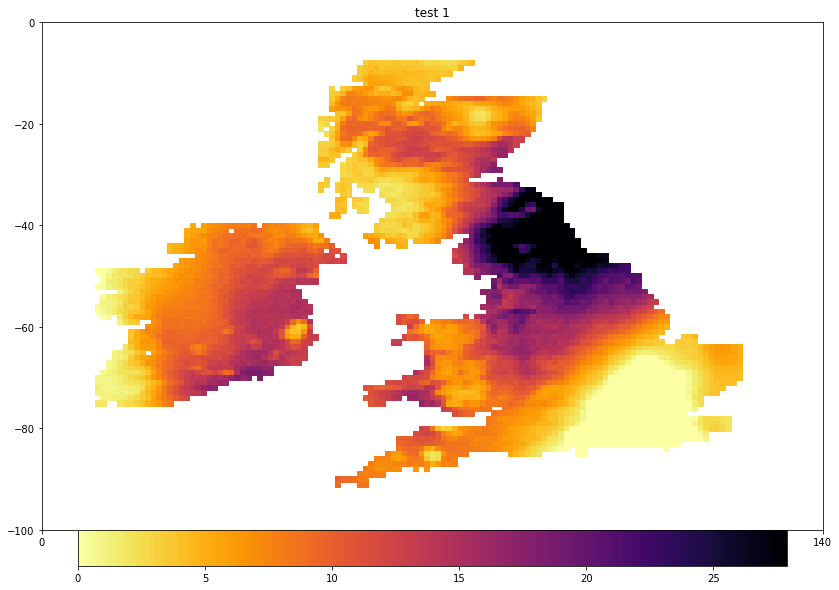

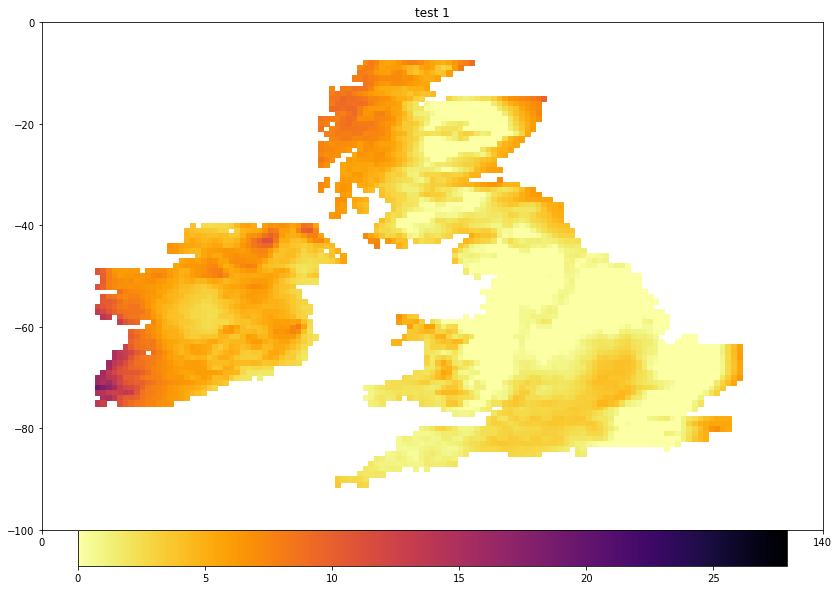

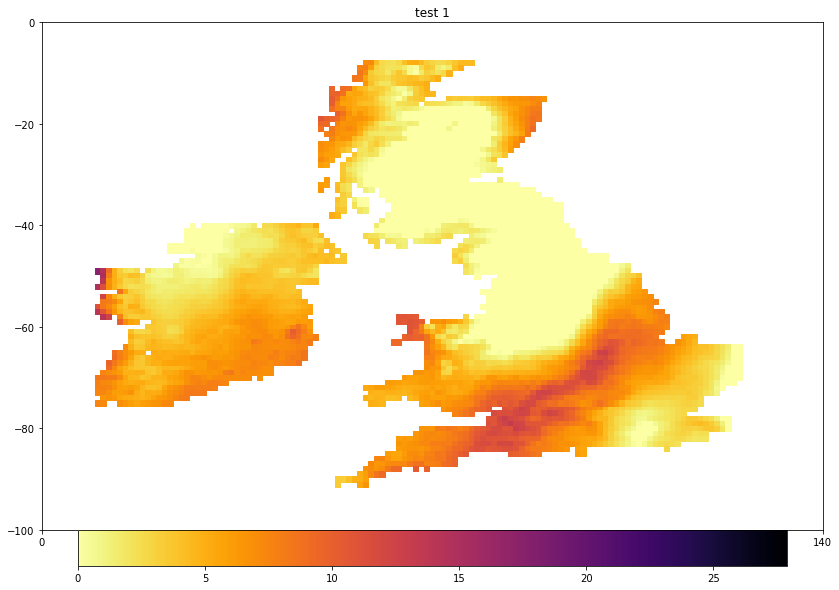

In [53]:
#plot ampled normals_uncesored

day_index = 320

fig = plt.gcf() 
fig.set_size_inches(14,10)

plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[l][3][day_index] for l in range(len(GNM_landonly))][:len(sim_test[0])],cmap='inferno_r',s=27,marker='s')
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('observed rain')
plt.show()

min_rain = min([GNM_landonly[l][3][day_index] for l in range(len(GNM_landonly))])
max_rain = max([GNM_landonly[l][3][day_index] for l in range(len(GNM_landonly))])

fig = plt.gcf() 
fig.set_size_inches(14,10)

plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=np.median(np.array([GNM_ppf(sim,day_index) for sim in sim_test]),axis=0),cmap='inferno_r',s=27,marker='s',vmin=min_rain,vmax=max_rain)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('Median simulated')
plt.show()

for idx,sim in enumerate(sim_test[:25]):
    '''fig = plt.gcf() 
    fig.set_size_inches(14,10)

    plt.xlim(0,140)
    plt.ylim(-100,0)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=GNM_ppf(sim_test2[idx][:len(sim_test[0])],day_index),cmap='inferno_r',s=27,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title(' test 2')
    plt.show()'''

    plt.xlim(0,140)
    plt.ylim(-100,0)
    fig = plt.gcf() 
    fig.set_size_inches(14,10)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=GNM_ppf(sim,day_index),cmap='inferno_r',s=27,marker='s',vmin=min_rain,vmax=max_rain)
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('test 1')
    plt.show()

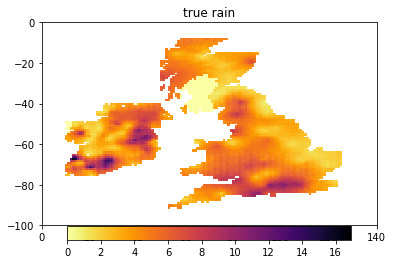

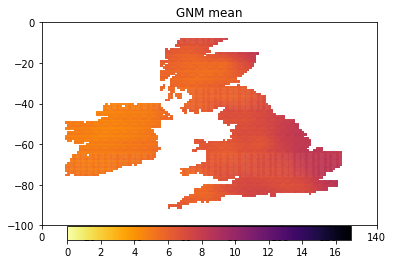

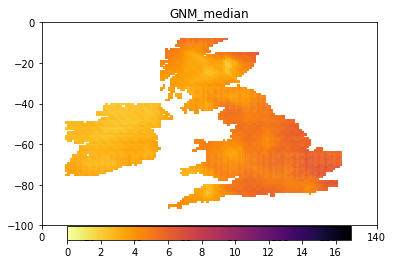

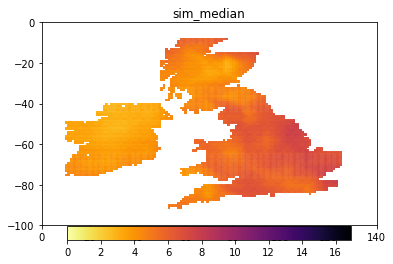

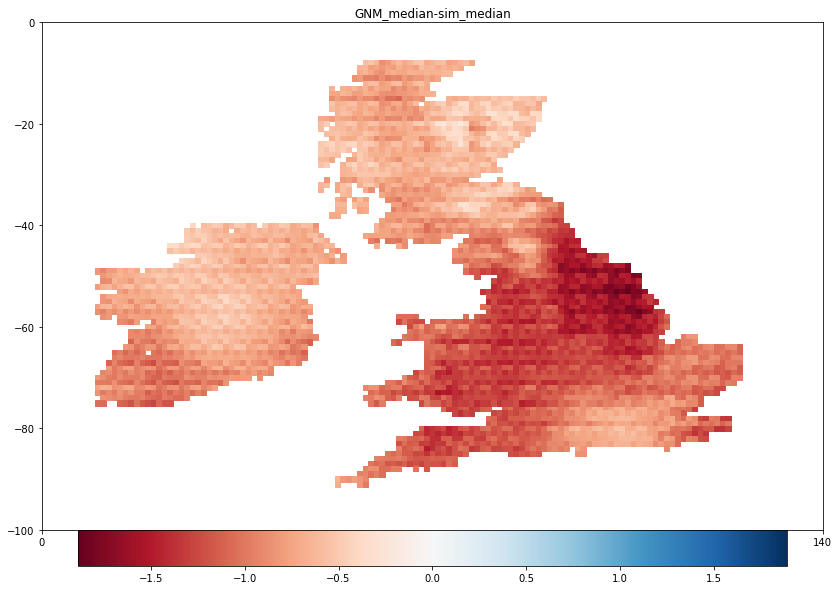

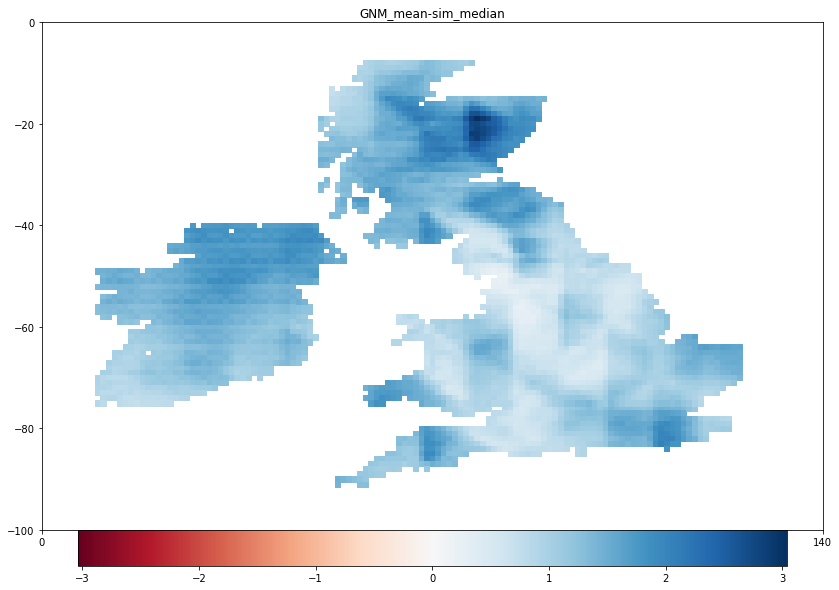

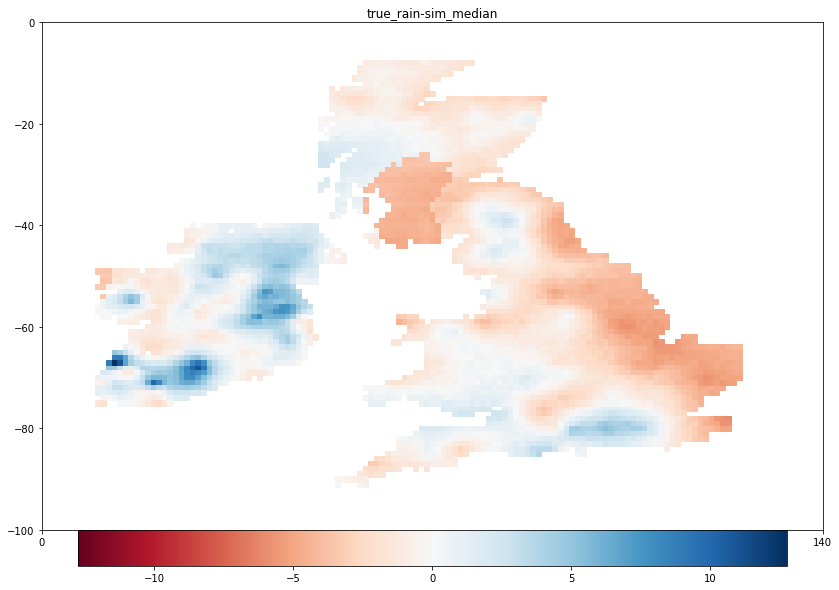

In [54]:
#Analysing biases introduces by copula sampling against GNM marginals.

true_median = scs.gamma(a=np.array([1/GNM_landonly[l][1][140] for l in range(len(GNM_landonly))]),
          scale=np.multiply( np.array([GNM_landonly[l][0][140] for l in range(len(GNM_landonly))]),np.array([GNM_landonly[l][1][140] for l in range(len(GNM_landonly))]) )).ppf(
    np.divide((np.array([GNM_landonly[l][4][140] for l in range(len(GNM_landonly))])-0.5),np.array([GNM_landonly[l][4][140] for l in range(len(GNM_landonly))]))
          )
sim_median = np.mean(np.array([GNM_ppf(sim_test[s],140) for s in range(len(sim_test))]),axis=0)

plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[loc][3][140] for loc in range(len(sim_test[0]))],cmap='inferno_r',s=2.8,marker='s')
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('true rain')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()
min_rain = np.min([GNM_landonly[loc][3][140] for loc in range(len(sim_test[0]))])
max_rain = np.max([GNM_landonly[loc][3][140] for loc in range(len(sim_test[0]))])

plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[loc][0][140] for loc in range(len(sim_test[0]))],cmap='inferno_r',s=2.8,marker='s',vmin=min_rain,vmax=max_rain)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('GNM mean')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=true_median,cmap='inferno_r',s=2.7,marker='s',vmin=min_rain,vmax=max_rain)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('GNM_median')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=sim_median,cmap='inferno_r',s=2.7,marker='s',vmin=min_rain,vmax=max_rain)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('sim_median')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()
fig = plt.gcf() 
fig.set_size_inches(14,10)
max_dif = np.max(np.abs(true_median-sim_median))
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=true_median-sim_median,cmap='RdBu',s=27,marker='s',vmin=-max_dif,vmax=max_dif)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('GNM_median-sim_median')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

fig = plt.gcf() 
fig.set_size_inches(14,10)
max_dif = np.max(np.abs([GNM_landonly[loc][0][140] for loc in range(len(sim_test[0]))]-sim_median))
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[loc][0][140] for loc in range(len(sim_test[0]))]-sim_median,cmap='RdBu',s=27,marker='s',vmin=-max_dif,vmax=max_dif)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('GNM_mean-sim_median')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

fig = plt.gcf() 
fig.set_size_inches(14,10)
max_dif = np.max(np.abs([GNM_landonly[loc][3][140] for loc in range(len(sim_test[0]))]-sim_median))
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[loc][3][140] for loc in range(len(sim_test[0]))]-sim_median,cmap='RdBu',s=27,marker='s',vmin=-max_dif,vmax=max_dif)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('true_rain-sim_median')
plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

### Covariance matrix testing

In [ ]:
cov_rain = np.cov(np.transpose(obs_norm_all))
sim_cov_rain = scs.multivariate_normal(mean=np.zeros(len(dist_mat)),cov=cov_rain).rvs(size=25)

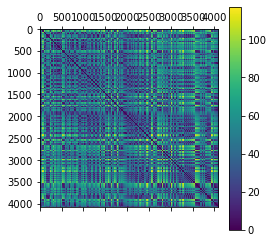

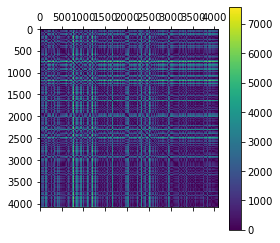

In [247]:
plt.matshow(dist_mat)
plt.colorbar()
plt.matshow(topo_dist)#
plt.colorbar()

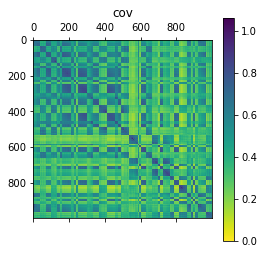

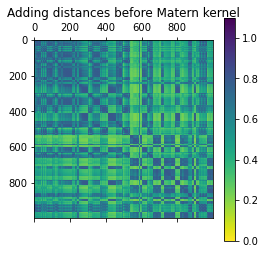

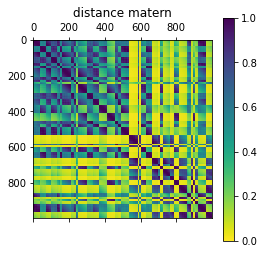

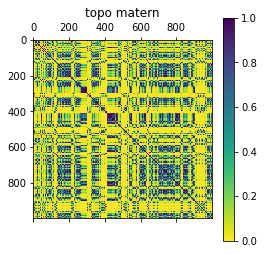

In [ ]:
lim_mat = [0,4087]
theta = [60,0.045,1/1500]
# SR [1.53735034e+02,3.5, 5.99074130e+03,3.5 ] #MLE:[208.33370545627545,3.5, 4500.88496935951,3.5]

plt.matshow(cov_rain[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]],cmap='viridis_r',vmin=0)
plt.colorbar()
plt.title('cov')


topo_matern = np.nan_to_num(Matern(length_scale=12000,nu=3.5).__call__(topo_dist[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]]))
dist_matern= np.nan_to_num(Matern(length_scale=600,nu=3.5).__call__(dist_mat[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]]))
cov_matern_add = 0.8* np.nan_to_num(Matern(length_scale=theta[0],nu=3.5).__call__(theta[1]*dist_mat[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]]+theta[2]*topo_dist[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]]))
plt.matshow(cov_matern_add,cmap='viridis_r',vmin=0,vmax=1.1)
plt.colorbar()
plt.title('Adding distances before Matern kernel')

plt.matshow(dist_matern,cmap='viridis_r',vmin=0)
plt.title('distance matern')
plt.colorbar()

plt.matshow(topo_matern,cmap='viridis_r',vmin=0)
plt.title('topo matern')
plt.colorbar()


Text(0.5, 1.0, 'cov')

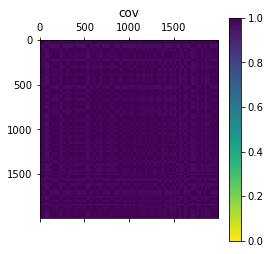

In [432]:
lim_mat = [0,2000]

plt.matshow(Matern(length_scale=9000,nu=3.5).__call__(dist_mat[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]]),cmap='viridis_r',vmin=0)
plt.colorbar()
plt.title('cov')

Text(0.5, 1.0, 'cov')

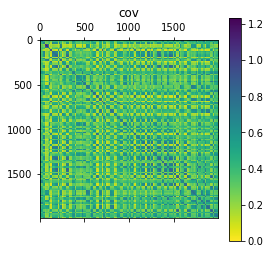

In [429]:
plt.matshow(cov_rain[lim_mat[0]:lim_mat[1],lim_mat[0]:lim_mat[1]],cmap='viridis_r',vmin=0)
plt.colorbar()
plt.title('cov')

### Working with elevation

In [98]:
import netCDF4 as nc
fn = 'topo_0.1_degree.nc'
ds = nc.Dataset(fn)
h = ds['Band1'][:]
h = np.flip(np.matrix(h),axis=0)
topo_dist = euclidean_distances(np.array([h[loc[5][0],loc[5][1]+2] for loc in GNM_landonly]).reshape(-1,1))

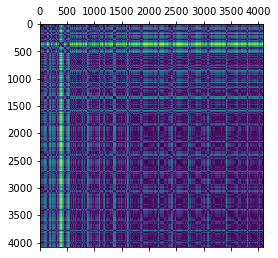

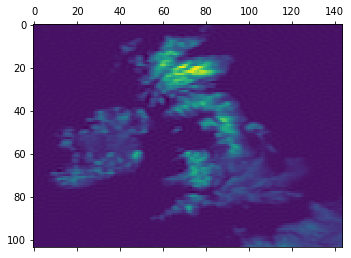

In [100]:
plt.matshow(topo_dist)
plt.show()
plt.matshow(h)